## ISSUE1: How good MCMAC describe a real data?

・'age' is absolute time

・'sep.kpc' is projected distance between two clusters

・'merger' shows the clusters is pre-merger or not

・'TSC_Catalog' shows Time Since Collision from Galaxy Cluster Merger Catalog. 

 We can calculate 
 
 TTC by "(1st apocentric passage's absolute time) - (TSC at 1st apocentric passage) - (dataframe's age) "
 
and 

TSC "(dataframe's age) - { (1st apocentric passage's absolute time) - (TSC at 1st apocentric passage)}".
 
 For simple dataframe, we replaced TTC to TSC by putting minus symbol
 
・'TSC0' shows Time Since Collision from MCMAC-pre-merger and MCMAC-post-merger

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import re
import seaborn as sns
from sklearn.model_selection import KFold
import scipy.stats

In [2]:
results_0_90 = []
results_0_20 = []
results_correlation_coefficient = []

In [3]:
def extract_parameters(filename):
    # Define the pattern to extract the parameters from the filename
    pattern = r'zh_(\d+)to(\d+)_b([\d.]+)_z_MCMAC.txt'
    
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    
    if match:
        # Extract the parameters
        param1 = match.group(1)
        param2 = match.group(2)
        b_value = match.group(3)
        
        # Format the parameters as "1:1 (b=0)"
        formatted_params = f"{param1}:{param2} (b={b_value})"
        
        return formatted_params
    else:
        return None

def pp_plot(data1, data2):
    # Sort both data sets
    ecdf1 = np.sort(data1)
    ecdf2 = np.sort(data2)
    
    # Calculate cumulative probabilities
    p1 = np.arange(1, len(ecdf1)+1) / len(ecdf1)
    p2 = np.arange(1, len(ecdf2)+1) / len(ecdf2)
    
    # Interpolate to find corresponding probabilities in the second data set
    p2_interp = np.interp(ecdf1, ecdf2, p2)
    
    # Plot P-P plot
    plt.figure(figsize=(8, 6))
    plt.plot(p1, p2_interp, 'o', label='Data')
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
    plt.xlabel('Cumulative Probability (Data1)')
    plt.ylabel('Cumulative Probability (Data2)')
    plt.title('P-P Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(mean, diff, *args, **kwargs, label='Data Points', alpha=0.6)
    plt.axhline(md, color='gray', linestyle='--', label='Mean Difference')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--', label='95% Limit of Agreement (+)')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--', label='95% Limit of Agreement (-)')
    
    plt.xlabel('Mean of MCMAC and Catalog Data')
    plt.ylabel('Difference between MCMAC and Catalog Data')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.show()



def plotImage(filename_default, filename_20degree, filename_45degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time):
    df_default = pd.read_csv(filename_default, sep='\t')
    df_selected_default = df_default[['age','sep.kpc','merger', 'delta.t', 'TSC0', 'TSC0.lower', 'TSC0.upper']]

    df_20degree = pd.read_csv(filename_20degree, sep='\t')
    df_selected_20degree = df_20degree[['age','sep.kpc','merger', 'delta.t', 'TSC0', 'TSC0.lower', 'TSC0.upper']]

    df_45degree = pd.read_csv(filename_45degree, sep='\t')
    df_selected_45degree = df_45degree[['age','sep.kpc','merger', 'delta.t', 'TSC0', 'TSC0.lower', 'TSC0.upper']]

    # When we replace Time Till Collision to Time Since Collision, we need to set minus.
    # We got Time Till Collision by using MCMAC-pre code.
    df_selected_default.loc[df_selected_default['merger'] == 'pre', ['TSC0', 'TSC0.lower', 'TSC0.upper']] *= -1
    df_selected_20degree.loc[df_selected_20degree['merger'] == 'pre', ['TSC0', 'TSC0.lower', 'TSC0.upper']] *= -1
    df_selected_45degree.loc[df_selected_20degree['merger'] == 'pre', ['TSC0', 'TSC0.lower', 'TSC0.upper']] *= -1

    # 相対誤差の計算
    df_selected_default = df_selected_default.copy()
    df_selected_default.loc[:, 'Absolute Residual'] = df_selected_default['TSC0'] - df_selected_default['delta.t']
    # df_selected_default.loc[:, 'Absolute Residual'] = df_selected_default['TSC0'] - df_selected_default['delta.t']
    
    df_selected_20degree = df_selected_20degree.copy()
    df_selected_20degree.loc[:,'Absolute Residual'] = df_selected_20degree['TSC0'] - df_selected_20degree['delta.t']
    
    df_selected_45degree = df_selected_45degree.copy()
    df_selected_45degree.loc[:,'Absolute Residual'] = df_selected_45degree['TSC0'] - df_selected_45degree['delta.t']

    # プロットスタイルの設定
    plt.style.use('ggplot')

    # 図とグリッドスペックの作成
    fig = plt.figure(figsize=(12, 18))
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])

    # delta.t の範囲でフィルタリング
    df_zoomed = df_selected_default[(df_selected_default['delta.t'] >= -0.3) & (df_selected_default['delta.t'] <= 0.3)]
    df_zoomed_20degree = df_selected_20degree[(df_selected_20degree['delta.t'] >= -0.3) & (df_selected_20degree['delta.t'] <= 0.3)]
    df_zoomed_45degree = df_selected_45degree[(df_selected_45degree['delta.t'] >= -0.3) & (df_selected_45degree['delta.t'] <= 0.3)]

    # 最上部プロット (拡大図)
    ax_zoom = fig.add_subplot(gs[0])
    line_zoom1 = ax_zoom.scatter(df_zoomed['delta.t'], df_zoomed['delta.t'], label='TSC from Catalog', color='black', s=64, marker='^')
    line_zoom2 = ax_zoom.errorbar(df_zoomed['delta.t'], df_zoomed['TSC0'], yerr=[np.abs(df_zoomed['TSC0'] - df_zoomed['TSC0.lower']), np.abs(df_zoomed['TSC0.upper'] - df_zoomed['TSC0'])], fmt='o', ecolor='red', capsize=5, markersize=6, color='red', label='TSC from MCMAC')
    # line_zoom4 = ax_zoom.errorbar(df_zoomed_45degree['delta.t'], df_zoomed_45degree['TSC0'], yerr=[np.abs(df_zoomed_45degree['TSC0'] - df_zoomed_45degree['TSC0.lower']), np.abs(df_zoomed_45degree['TSC0.upper'] - df_zoomed_45degree['TSC0'])], fmt='o', ecolor='blue', capsize=5, markersize=6, color='blue', label='TSC from MCMAC with 0-60 degree')
    # line_zoom3 = ax_zoom.errorbar(df_zoomed_20degree['delta.t'], df_zoomed_20degree['TSC0'], yerr=[np.abs(df_zoomed_20degree['TSC0'] - df_zoomed_20degree['TSC0.lower']), np.abs(df_zoomed_20degree['TSC0.upper'] - df_zoomed_20degree['TSC0'])], fmt='o', ecolor='green', capsize=5, markersize=6, color='green', label='TSC from MCMAC with 0-20 degree')

    # 縦の点線を追加
    ax_zoom.axvline(color='black', linestyle='--')
    ax_zoom.axhline(color='black', linestyle='--')


    ax_zoom.set_xlabel('delta.t (TSC from catalogue)', fontsize=17)
    ax_zoom.set_ylabel('TSC (Gyr)', fontsize=17)
    ax_zoom.set_xlim(zoom_x_range[0], zoom_x_range[1])
    ax_zoom.set_ylim(zoom_y_range[0], zoom_y_range[1])

    # lines_zoom = [line_zoom1, line_zoom2, line_zoom3, line_zoom4]
    lines_zoom = [line_zoom1, line_zoom2]
    labels_zoom = [l.get_label() for l in lines_zoom]
    ax_zoom.legend(lines_zoom, labels_zoom, loc='upper left')

    # 上部プロット
    ax1 = fig.add_subplot(gs[1])
    line1 = ax1.scatter(df_selected_default['age'], df_selected_default['delta.t'], label='TSC from Catalog', color='black', s=64, marker='^')
    ax1.set_xlabel('Absolute age (Gyr)', fontsize=17)
    ax1.set_ylabel('TSC (Gyr)', fontsize=17)
    ax1.set_xlim(plot1_x_range[0], plot1_x_range[1])
    ax1.set_ylim(plot1_y_range[0], plot1_y_range[1])
    ax1.axvline(x=absolute_merge_time, color='black', linestyle='--')
    ax1.axhline(color='black', linestyle='--')

    ax2 = ax1.twinx()
    line2 = ax2.errorbar(df_selected_default['age'], df_selected_default['TSC0'], yerr=[np.abs(df_selected_default['TSC0'] - df_selected_default['TSC0.lower']), np.abs(df_selected_default['TSC0.upper'] - df_selected_default['TSC0'])], fmt='o', ecolor='red', capsize=5, markersize=6, color='red', label='TSC from MCMAC')
    # line8 = ax2.errorbar(df_selected_45degree['age'], df_selected_45degree['TSC0'], yerr=[np.abs(df_selected_45degree['TSC0'] - df_selected_45degree['TSC0.lower']), np.abs(df_selected_45degree['TSC0.upper'] - df_selected_45degree['TSC0'])], fmt='o', ecolor='blue', capsize=5, markersize=6, color='blue', label='TSC from MCMAC with 0-60 degree')
    # line3 = ax2.errorbar(df_selected_20degree['age'], df_selected_20degree['TSC0'], yerr=[np.abs(df_selected_20degree['TSC0'] - df_selected_20degree['TSC0.lower']), np.abs(df_selected_20degree['TSC0.upper'] - df_selected_20degree['TSC0'])], fmt='o', ecolor='green', capsize=5, markersize=6, color='green', label='TSC from MCMAC with 0-20 degree')

    ax7 = ax1.twiny()
    ax7.set_xlim(ax1.get_xlim())
    ax7.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax7.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax7.set_xlabel('delta.t (TSC from catalogue)', fontsize=17)

    # lines = [line1, line2, line3, line8]
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # 中部プロット
    ax3 = fig.add_subplot(gs[2])
    line4 = ax3.plot(df_selected_default['age'], df_selected_default['Absolute Residual'], 'r-', label='Default', marker='o', markersize=5)
    # line5 = ax3.plot(df_selected_20degree['age'], df_selected_20degree['Absolute Residual'], '-', label='0-20 degree', marker='o', markersize=5, color='green')
    # line9 = ax3.plot(df_selected_45degree['age'], df_selected_45degree['Absolute Residual'], '-', label='0-60 degree', marker='o', markersize=5, color='blue')

    ax3.set_xlabel('Absolute age (Gyr)', fontsize=17)
    ax3.set_ylabel('Absolute Residual (Gyr)', fontsize=17)
    ax3.set_xlim(plot2_x_range[0], plot2_x_range[1])
    ax3.set_ylim(plot2_y_range[0], plot2_y_range[1])
    ax3.axhline(color='black', linestyle='--')
    ax3.axvline(x=absolute_merge_time, color='black', linestyle='--')

    ax6 = ax3.twiny()
    ax6.set_xlim(ax3.get_xlim())
    ax6.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax6.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax6.set_xlabel('delta.t (TSC from catalogue)')

    # 縦の点線を第2x軸に追加
    ax6.axvline(x=0.00, color='black', linestyle='--')

    # lines_mid = [line4[0], line5[0], line9[0]]
    lines_mid = [line4[0]]

    labels_mid = [l.get_label() for l in lines_mid]
    ax3.legend(lines_mid, labels_mid, loc='upper left')

    # 下部プロット
    ax4 = fig.add_subplot(gs[3])
    ax4.plot(df_selected_default['age'], df_selected_default['sep.kpc'], 'b-', label='Halo Separation', marker='o', markersize=5)
    ax4.set_xlabel('Absolute age (Gyr)', fontsize=17)
    ax4.set_ylabel('Halo Separation (kpc)', fontsize=17)
    ax4.set_xlim(plot3_x_range[0], plot3_x_range[1])
    ax4.set_ylim(plot3_y_range[0], plot3_y_range[1])
    ax4.axvline(x=absolute_merge_time, color='black', linestyle='--')


    ax5 = ax4.twiny()
    ax5.set_xlim(ax4.get_xlim())
    ax5.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['delta.t'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax5.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax5.set_xlabel('delta.t (TSC from catalogue)')

    # 縦の点線を第2x軸に追加
    ax5.axvline(x=0.00, color='black', linestyle='--')
    
    filename_default = extract_parameters(filename_default)
    
    #  Correlation Coefficient
    y_true = df_selected_default['delta.t']
    y_pred = df_selected_default['TSC0']
    
    correlation = scipy.stats.pearsonr(y_true, y_pred)[0]
    print(f'Pearson Correlation Coefficient: {correlation:.2f}')
    results_correlation_coefficient.append({
        "filename": filename_default,
        "CorrelationCoefficient": correlation
    })

    # Calculate metrics
    mae_default = mean_absolute_error(df_selected_default['delta.t'], df_selected_default['TSC0'])
    rmse_default = np.sqrt(mean_squared_error(df_selected_default['delta.t'], df_selected_default['TSC0']))
    r2_default = r2_score(df_selected_default['delta.t'], df_selected_default['TSC0'])

    mae_20degree = mean_absolute_error(df_selected_20degree['delta.t'], df_selected_20degree['TSC0'])
    rmse_20degree = np.sqrt(mean_squared_error(df_selected_20degree['delta.t'], df_selected_20degree['TSC0']))
    r2_20degree = r2_score(df_selected_20degree['delta.t'], df_selected_20degree['TSC0'])

    plt.tight_layout()
    plt.show()

    
    # Print metrics
    # print(f"Metrics for default angle:")
    # print(f"MAE: {mae_default}")
    # print(f"RMSE: {rmse_default}")
    # print(f"R²: {r2_default}")
    results_0_90.append({
        "filename": filename_default,
        "MAE": mae_default,
        "RMSE": rmse_default,
        "R²": r2_default
    })

    filename_20degree = extract_parameters(filename_20degree)
    # print(f"\nMetrics for 20-degree angle:")
    # print(f"MAE: {mae_20degree}")
    # print(f"RMSE: {rmse_20degree}")
    # print(f"R²: {r2_20degree}")
    results_0_20.append({
        "filename": filename_20degree,
        "MAE": mae_20degree,
        "RMSE": rmse_20degree,
        "R²": r2_20degree
    })
    
    """クロスバリデーション"""
    # クロスバリデーションの設定
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # 評価指標のリスト
    mae_scores = []
    rmse_scores = []
    r2_scores = []
    correlation_scores = []

    # 各分割での評価を計算
    for train_index, test_index in kf.split(y_true):
        y_train, y_test = y_true[train_index], y_true[test_index]
        y_pred_train, y_pred_test = y_pred[train_index], y_pred[test_index]

        mae_scores.append(mean_absolute_error(y_test, y_pred_test))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        r2_scores.append(r2_score(y_test, y_pred_test))
        correlation_scores.append(scipy.stats.pearsonr(y_test, y_pred_test)[0])

    # 結果の表示
    print(f'Cross-Validated MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}')
    print(f'Cross-Validated RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}')
    print(f'Cross-Validated R²: {np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}')
    print(f'Cross-Validated Correlation Coefficient: {np.mean(correlation_scores):.2f} ± {np.std(correlation_scores):.2f}')

    # 結果をデータフレームにまとめる
    results_df = pd.DataFrame({
        'MAE': mae_scores,
        'RMSE': rmse_scores,
        'R²': r2_scores,
        'Correlation Coefficient': correlation_scores
    })

    # 結果のデータフレームを表示
    print("Cross-Validation Results:")
    display(results_df)
    
    """Bland-Altmanプロット"""
    # MCMACの予測値（y_pred）とカタログデータの実際の値（y_true）を使用してプロットを作成します
    # print("y_test", y_test)
    # print("y_pred", y_pred)
    bland_altman_plot(y_true, y_pred)


## Mass ratio 1:1 b=0kpc

Pearson Correlation Coefficient: 0.97


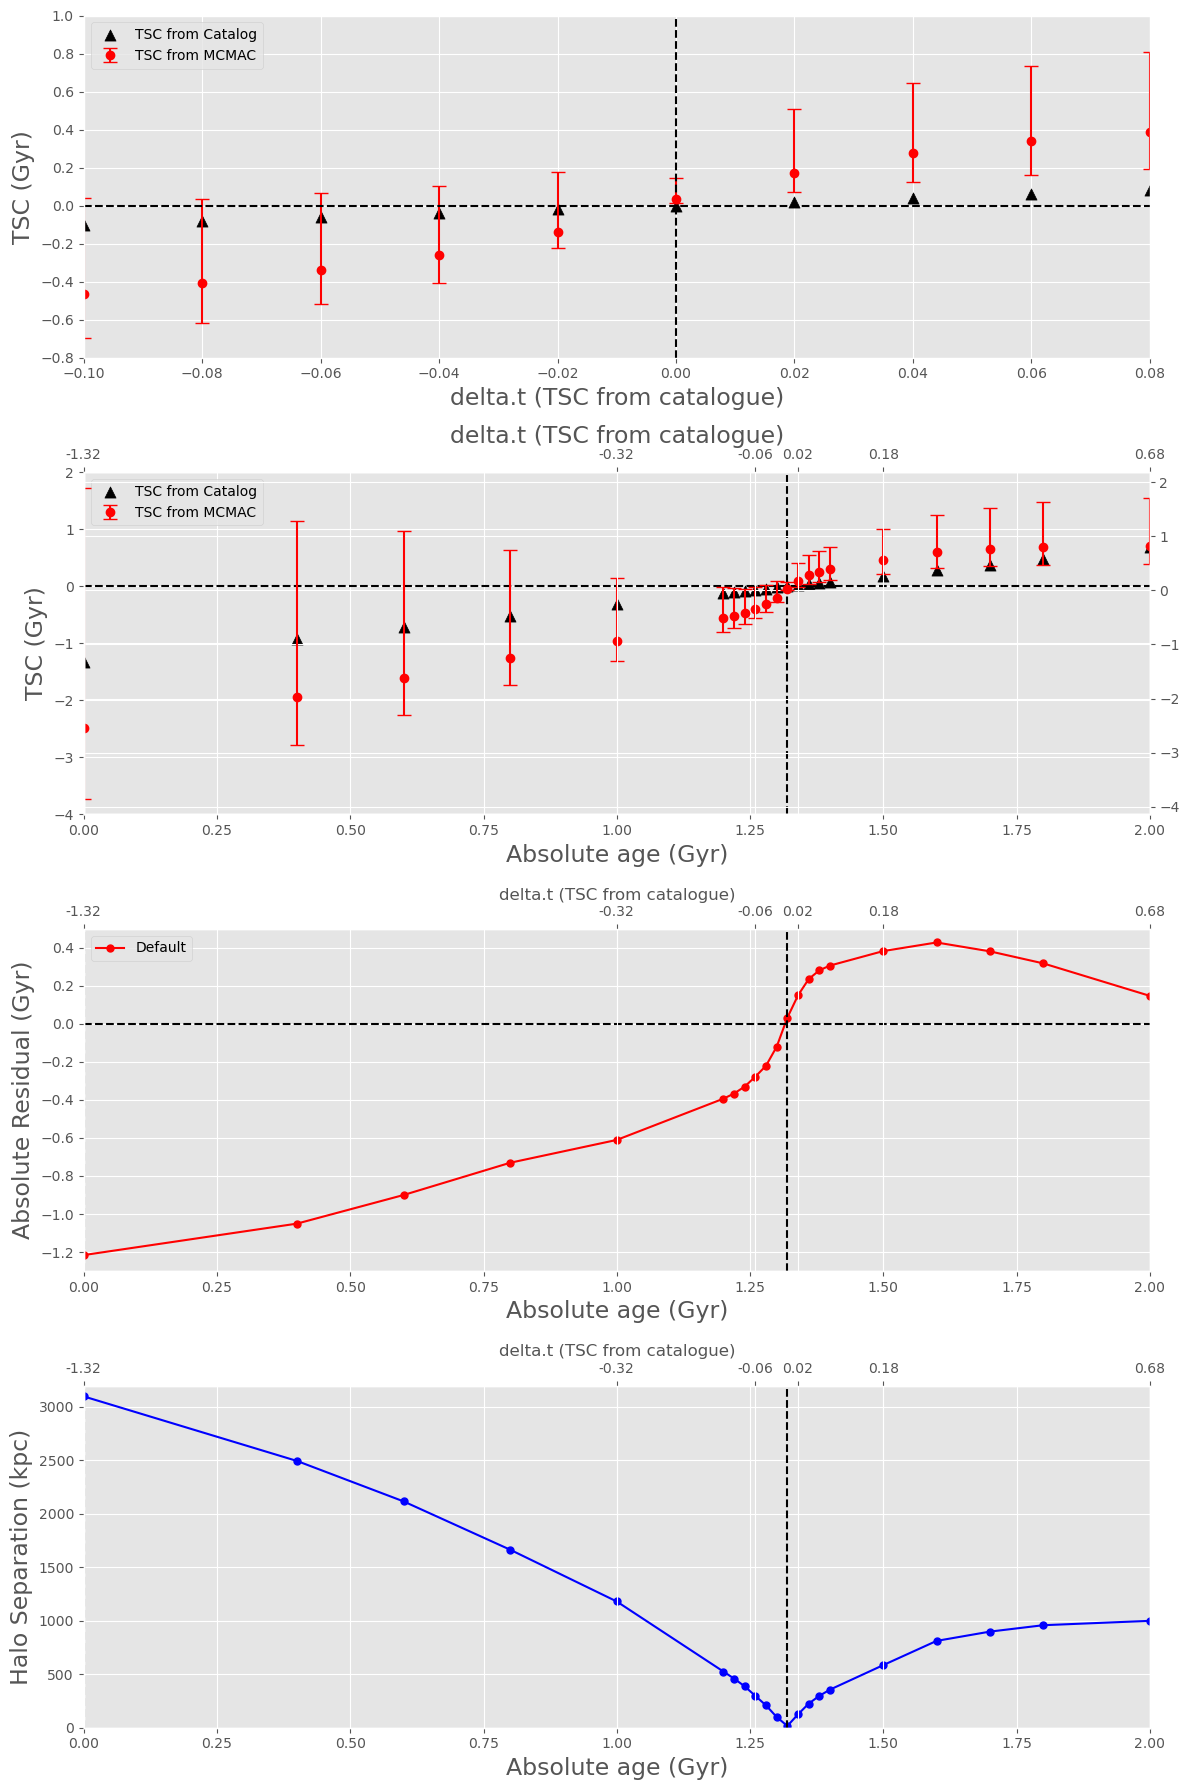

Cross-Validated MAE: 0.41 ± 0.17
Cross-Validated RMSE: 0.46 ± 0.20
Cross-Validated R²: -9.98 ± 11.27
Cross-Validated Correlation Coefficient: 1.00 ± 0.00
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.650549,0.765231,-0.155747,0.999689
1,0.663967,0.768334,-2.192738,1.000000
2,0.212991,0.279110,-20.639619,1.000000
3,0.556131,0.582782,-0.677208,1.000000
4,0.309536,0.318193,-19.662547,1.000000
5,0.559986,0.655164,-2.713143,1.000000
6,0.378989,0.443991,0.211489,1.000000
7,0.239912,0.256139,-25.242802,1.000000
8,0.200948,0.216670,-28.341053,1.000000
9,0.342492,0.343319,-0.401518,1.000000


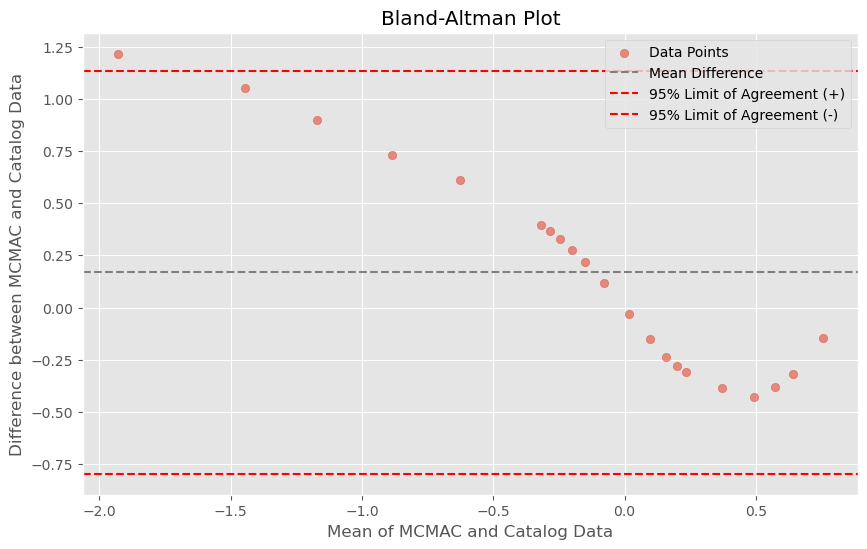

In [4]:
filename_default = '../output_default/zh_1to1_b0_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to1_b0_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to1_b0_z_MCMAC.txt'

zoom_x_range = [-0.1, 0.08]
zoom_y_range = [-0.8, 1]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3200]
absolute_merge_time = 2 - 0.68

plotImage(filename_default, filename_20degree, filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:1 b=500kpc

Pearson Correlation Coefficient: 0.98


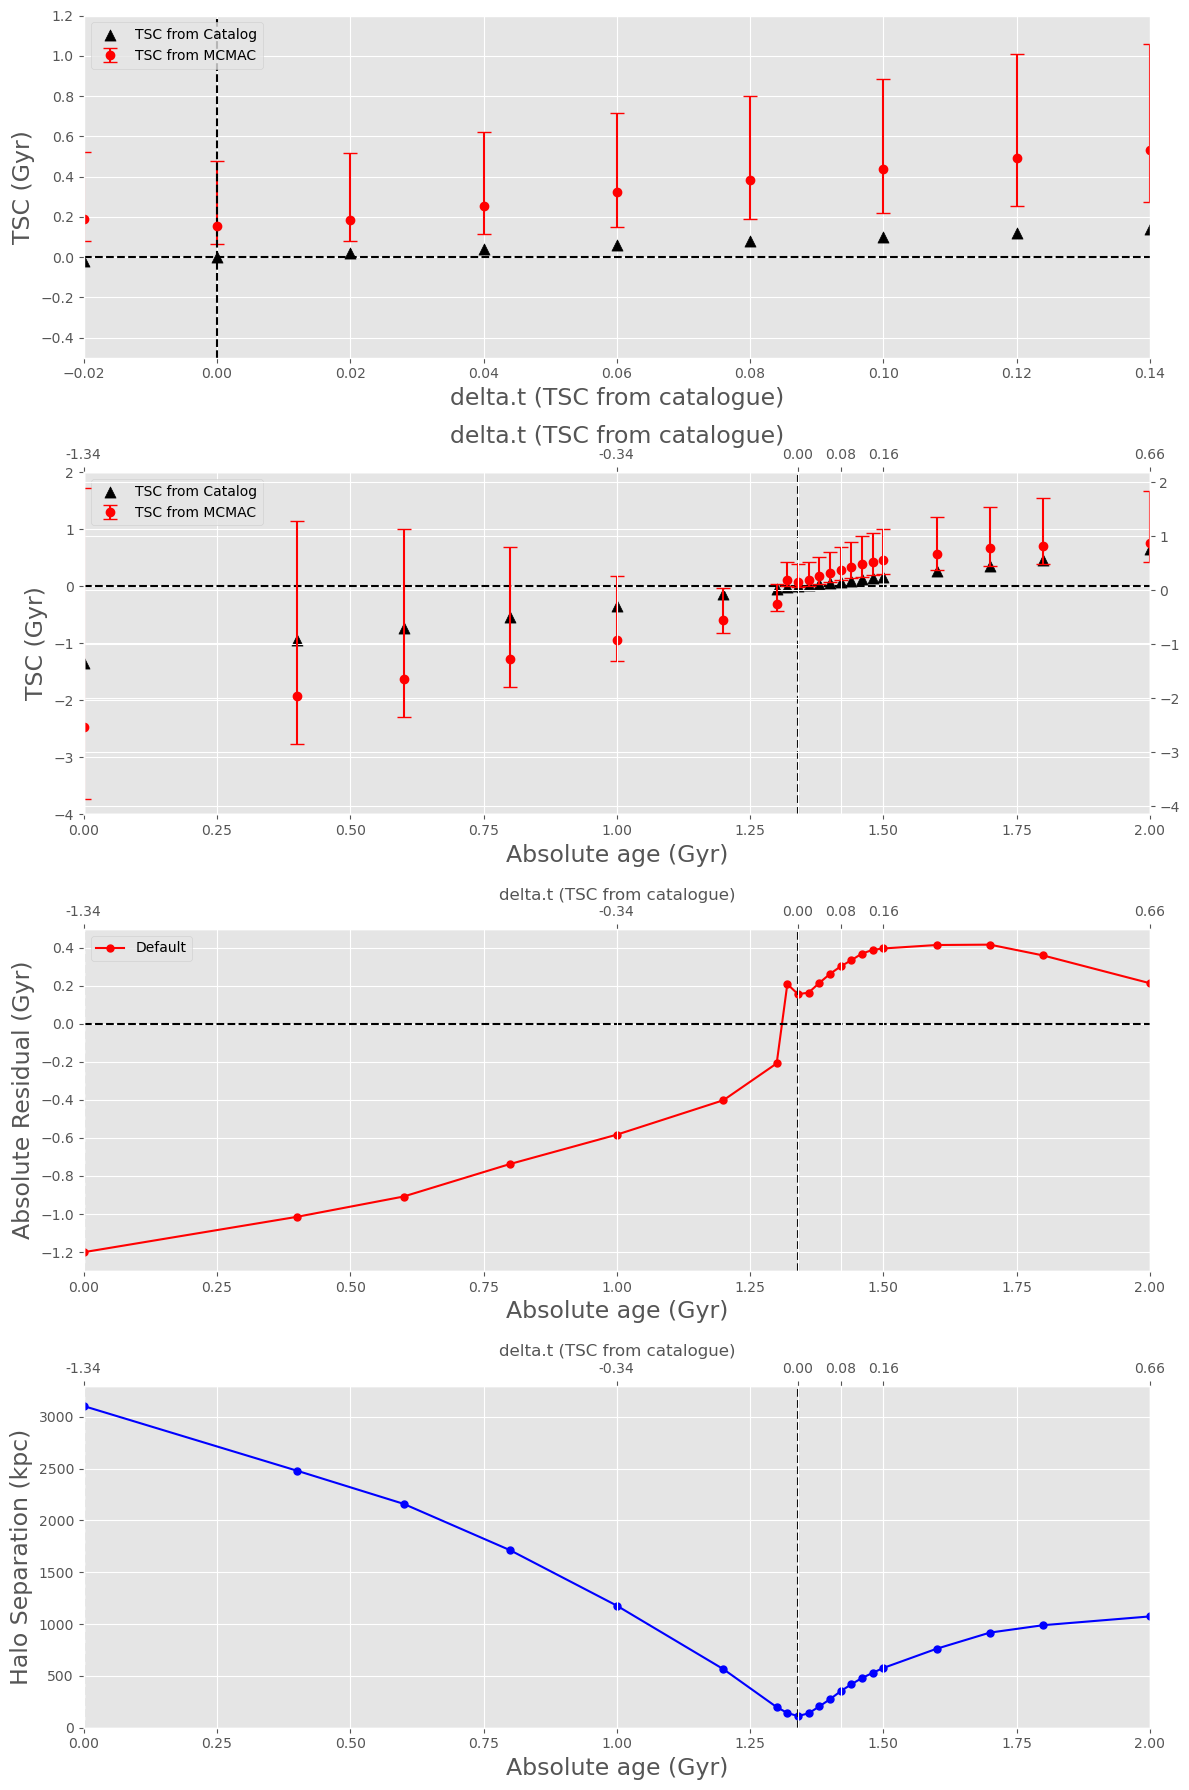

Cross-Validated MAE: 0.43 ± 0.14
Cross-Validated RMSE: 0.47 ± 0.18
Cross-Validated R²: -24.63 ± 44.82
Cross-Validated Correlation Coefficient: 1.00 ± 0.00
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.668488,0.767278,-0.111997,0.999629
1,0.585560,0.726054,-1.386391,1.000000
2,0.332222,0.339364,-10.516787,1.000000
3,0.576928,0.598652,-0.769799,1.000000
4,0.366025,0.367332,-148.925177,1.000000
5,0.536465,0.652612,-1.949464,1.000000
6,0.398498,0.438981,0.229184,1.000000
7,0.256210,0.260383,-26.119668,1.000000
8,0.292963,0.302967,-56.368085,1.000000
9,0.283999,0.294048,-0.383423,1.000000


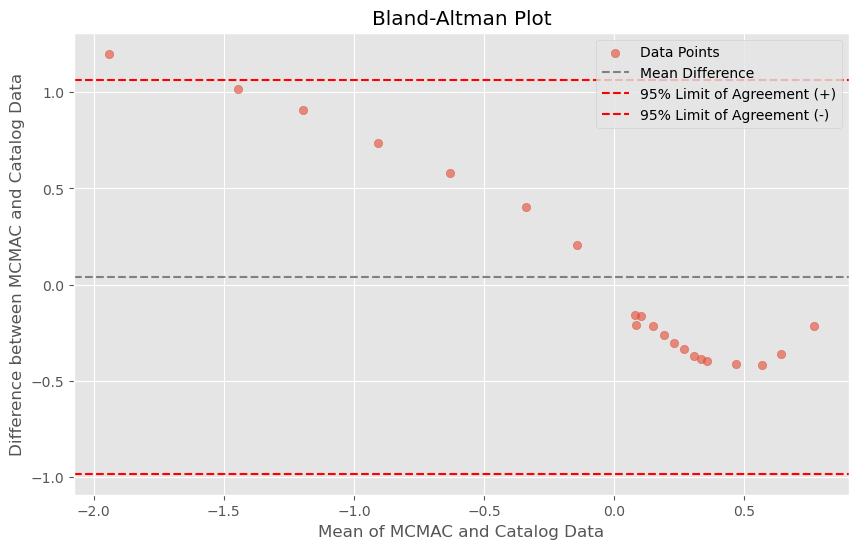

In [5]:
filename_default = '../output_default/zh_1to1_b0.5_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to1_b0.5_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to1_b0.5_z_MCMAC.txt'


zoom_x_range = [-0.02, 0.14]
zoom_y_range = [-0.5, 1.2]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3300]
absolute_merge_time = 2 - 0.66

plotImage(filename_default, filename_20degree,filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:1 b=1000kpc

Pearson Correlation Coefficient: 0.97


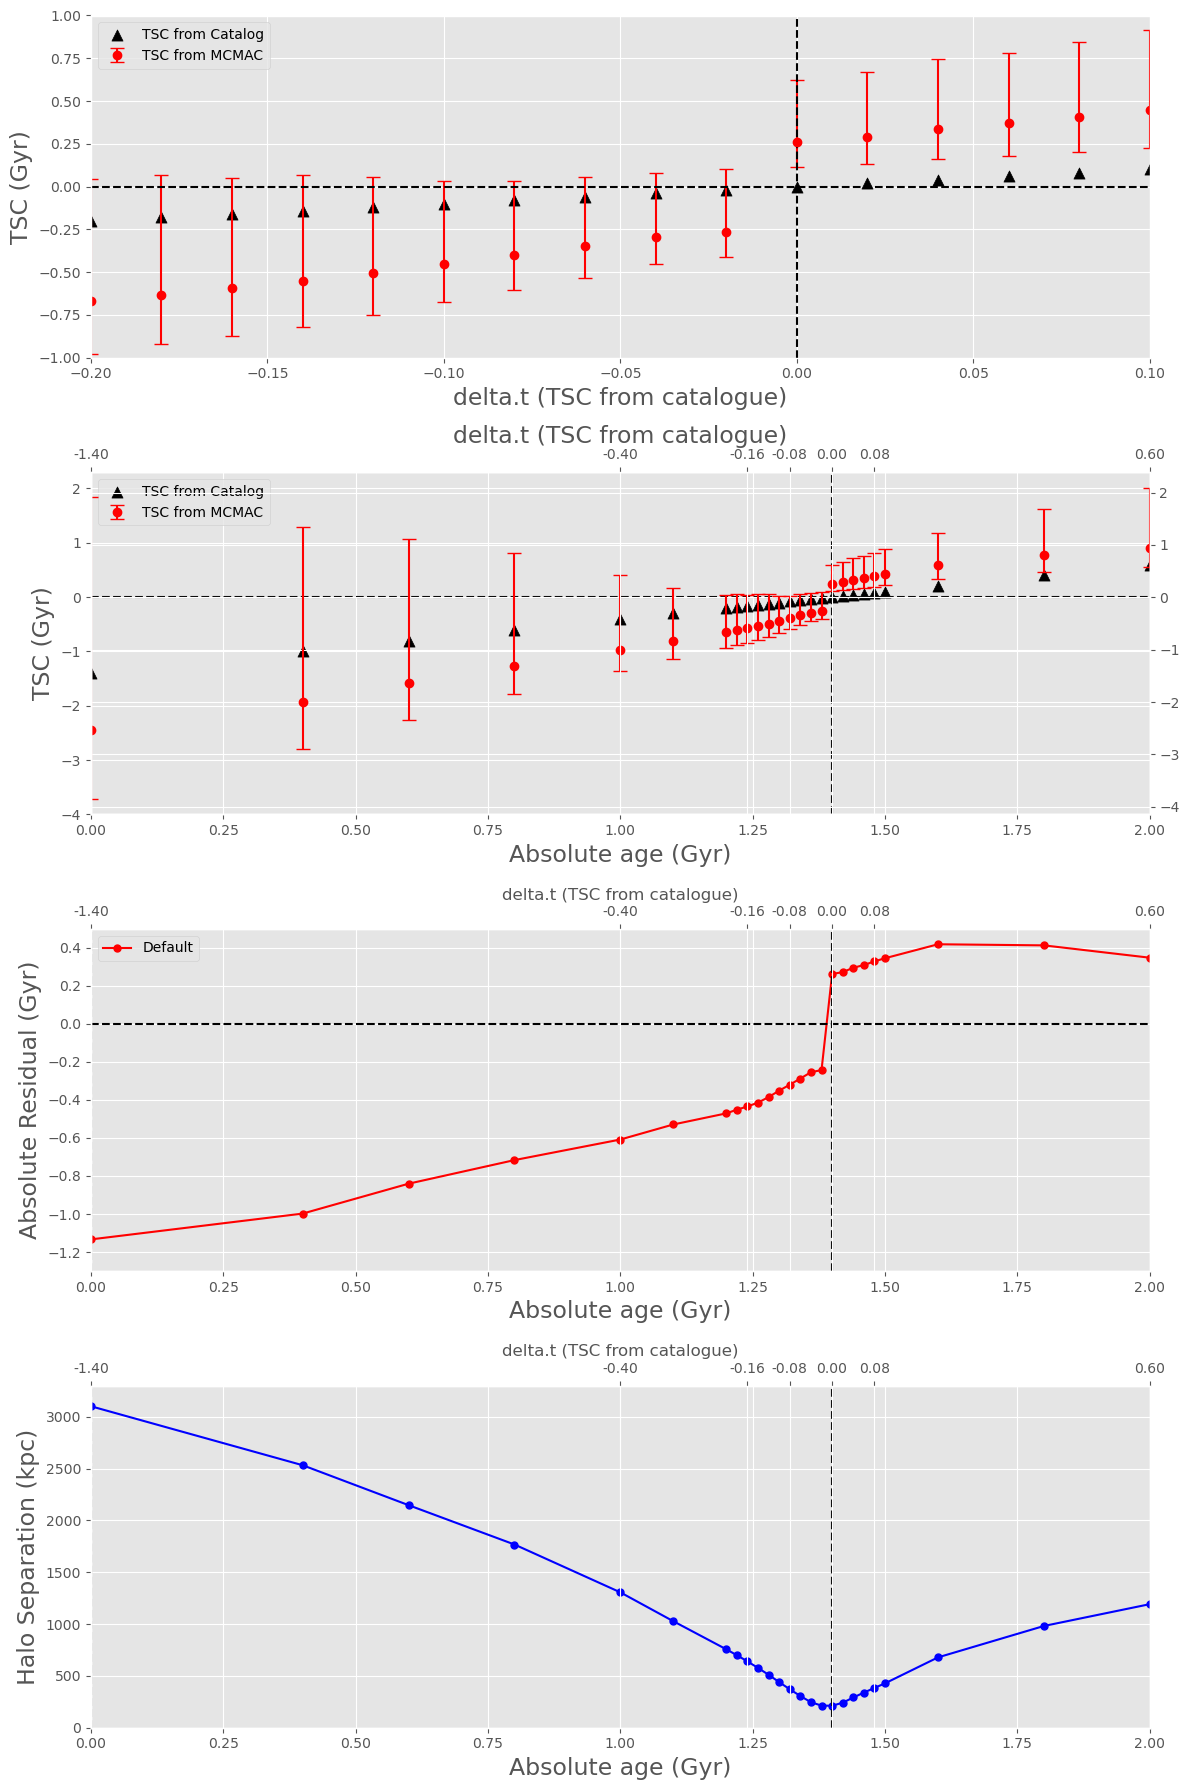

Cross-Validated MAE: 0.44 ± 0.11
Cross-Validated RMSE: 0.47 ± 0.14
Cross-Validated R²: -29.82 ± 43.09
Cross-Validated Correlation Coefficient: 1.00 ± 0.01
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.610130,0.717062,-0.313464,0.980248
1,0.392789,0.393902,-1.570751,0.999999
2,0.568070,0.646472,-0.572993,0.986187
3,0.563122,0.602400,-2.998499,0.998998
4,0.522439,0.560364,-4.426394,0.998328
5,0.300941,0.302269,-100.518468,1.000000
6,0.320595,0.321573,-113.899342,1.000000
7,0.399833,0.403129,-0.068461,1.000000
8,0.319489,0.326109,-65.467101,1.000000
9,0.390228,0.398422,-8.392918,1.000000


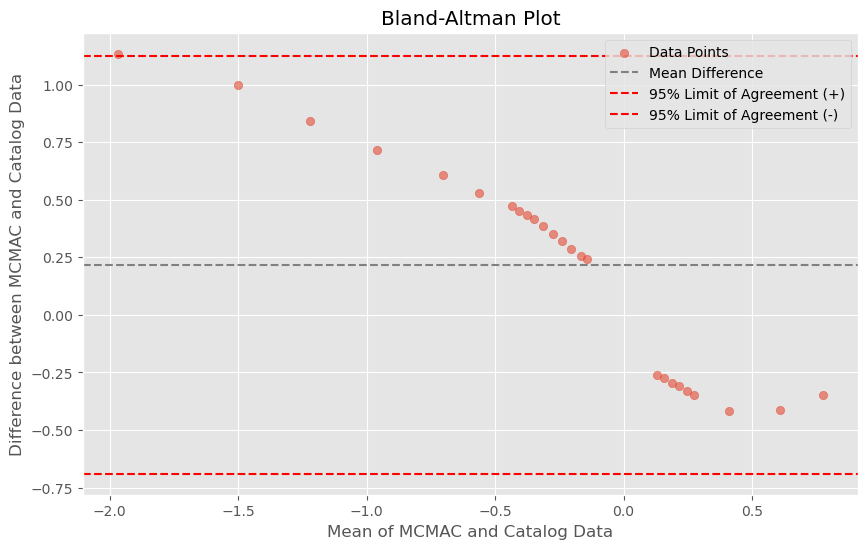

In [6]:
filename_default = '../output_default/zh_1to1_b1_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to1_b1_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to1_b1_z_MCMAC.txt'

zoom_x_range = [-0.2, 0.1]
zoom_y_range = [-1, 1]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2.3]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3300]
absolute_merge_time = 2 - 0.6

plotImage(filename_default, filename_20degree, filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:3 b=0kpc

Pearson Correlation Coefficient: 0.97


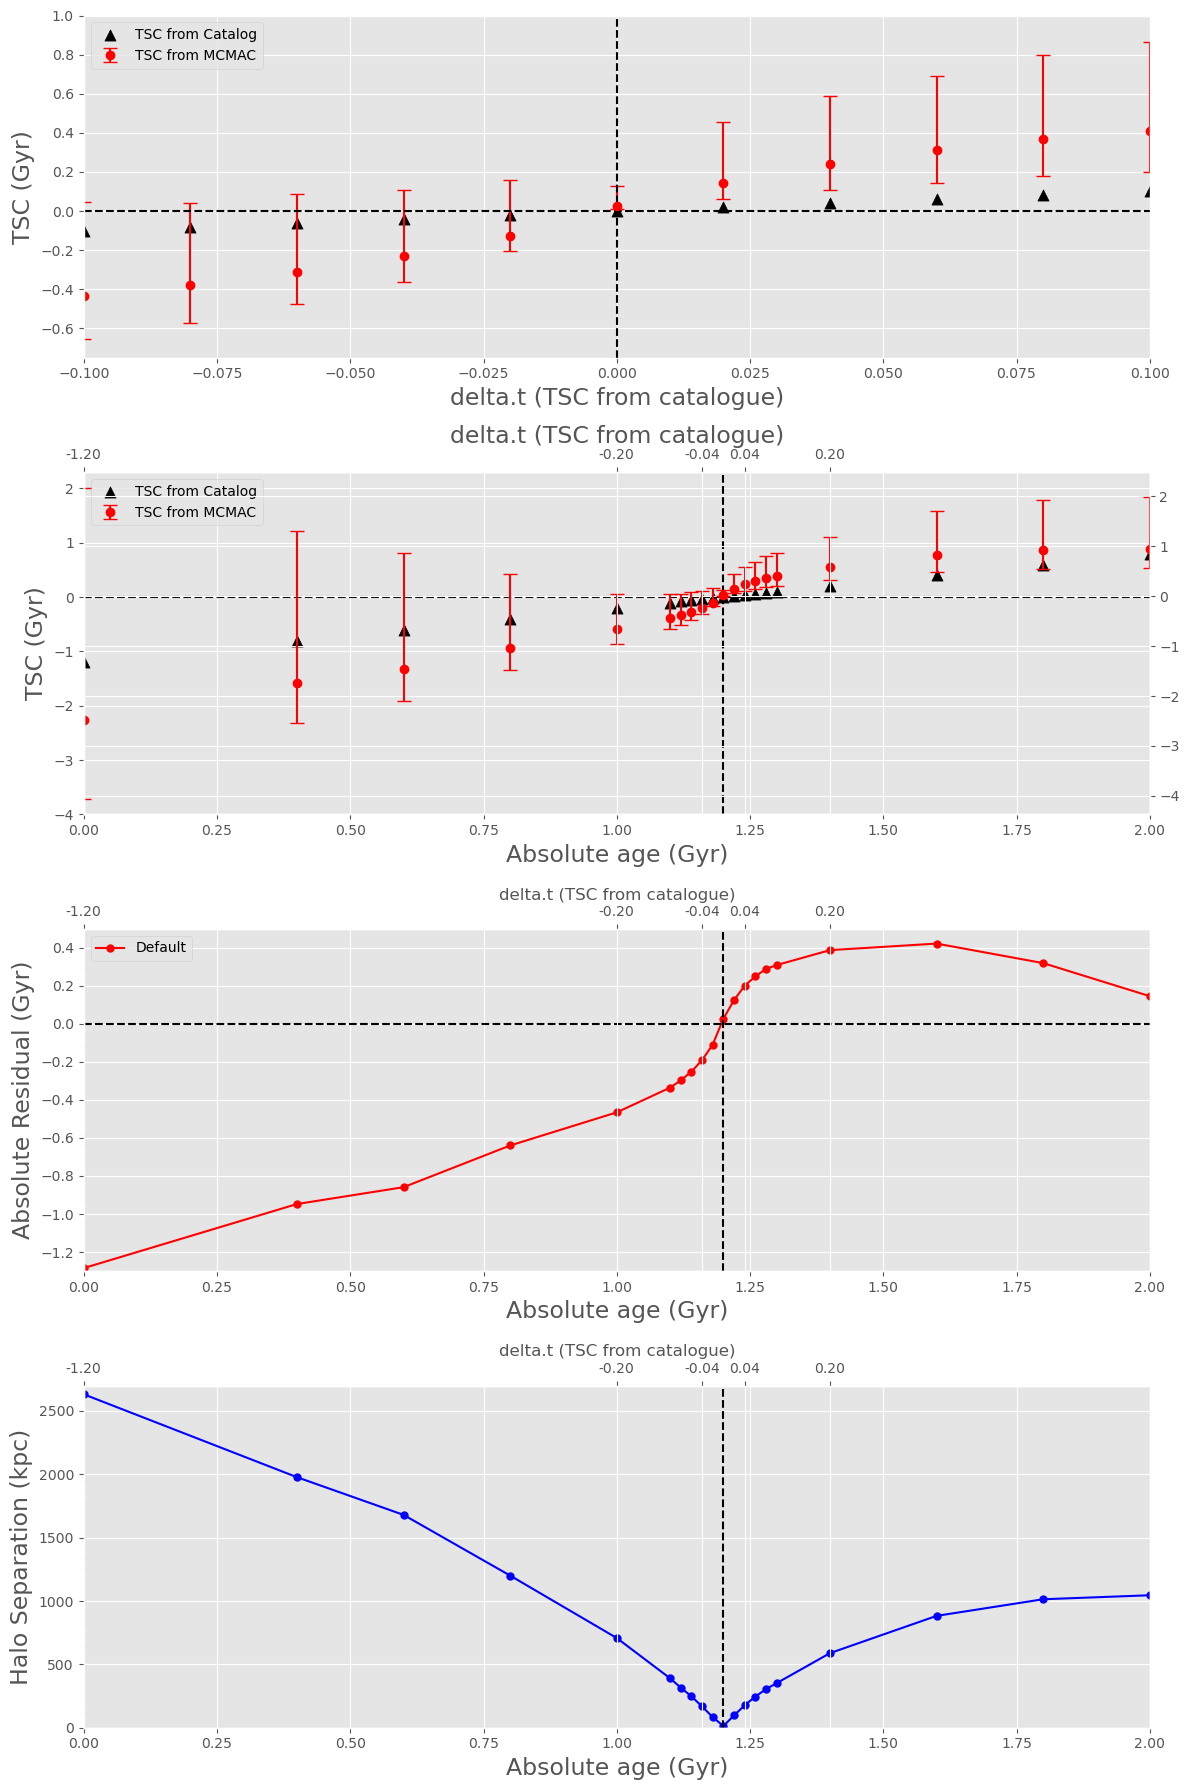

Cross-Validated MAE: 0.39 ± 0.21
Cross-Validated RMSE: 0.43 ± 0.25
Cross-Validated R²: -14.61 ± 24.44
Cross-Validated Correlation Coefficient: 1.00 ± 0.00
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.853613,0.956216,-0.428671,1.0
1,0.628603,0.704868,-1.453523,1.0
2,0.263085,0.272838,-81.711864,1.0
3,0.382400,0.460791,-3.814699,1.0
4,0.354100,0.355741,-2.163799,1.0
5,0.554521,0.632537,-2.674037,1.0
6,0.127286,0.128655,0.901534,1.0
7,0.333106,0.358349,-7.917639,1.0
8,0.139223,0.178502,-34.403217,1.0
9,0.293104,0.293130,-12.425803,1.0


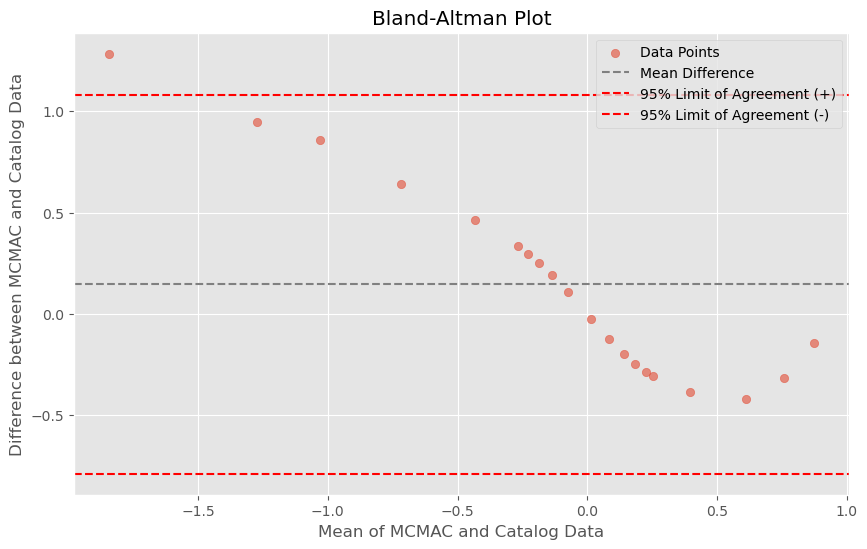

In [7]:
filename_default = '../output_default/zh_1to3_b0_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to3_b0_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to3_b0_z_MCMAC.txt'


zoom_x_range = [-0.1, 0.1]
zoom_y_range = [-0.75, 1]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2.3]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 2700]
absolute_merge_time = 2 - 0.8

plotImage(filename_default, filename_20degree, filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:3 b=500kpc

Pearson Correlation Coefficient: 0.97


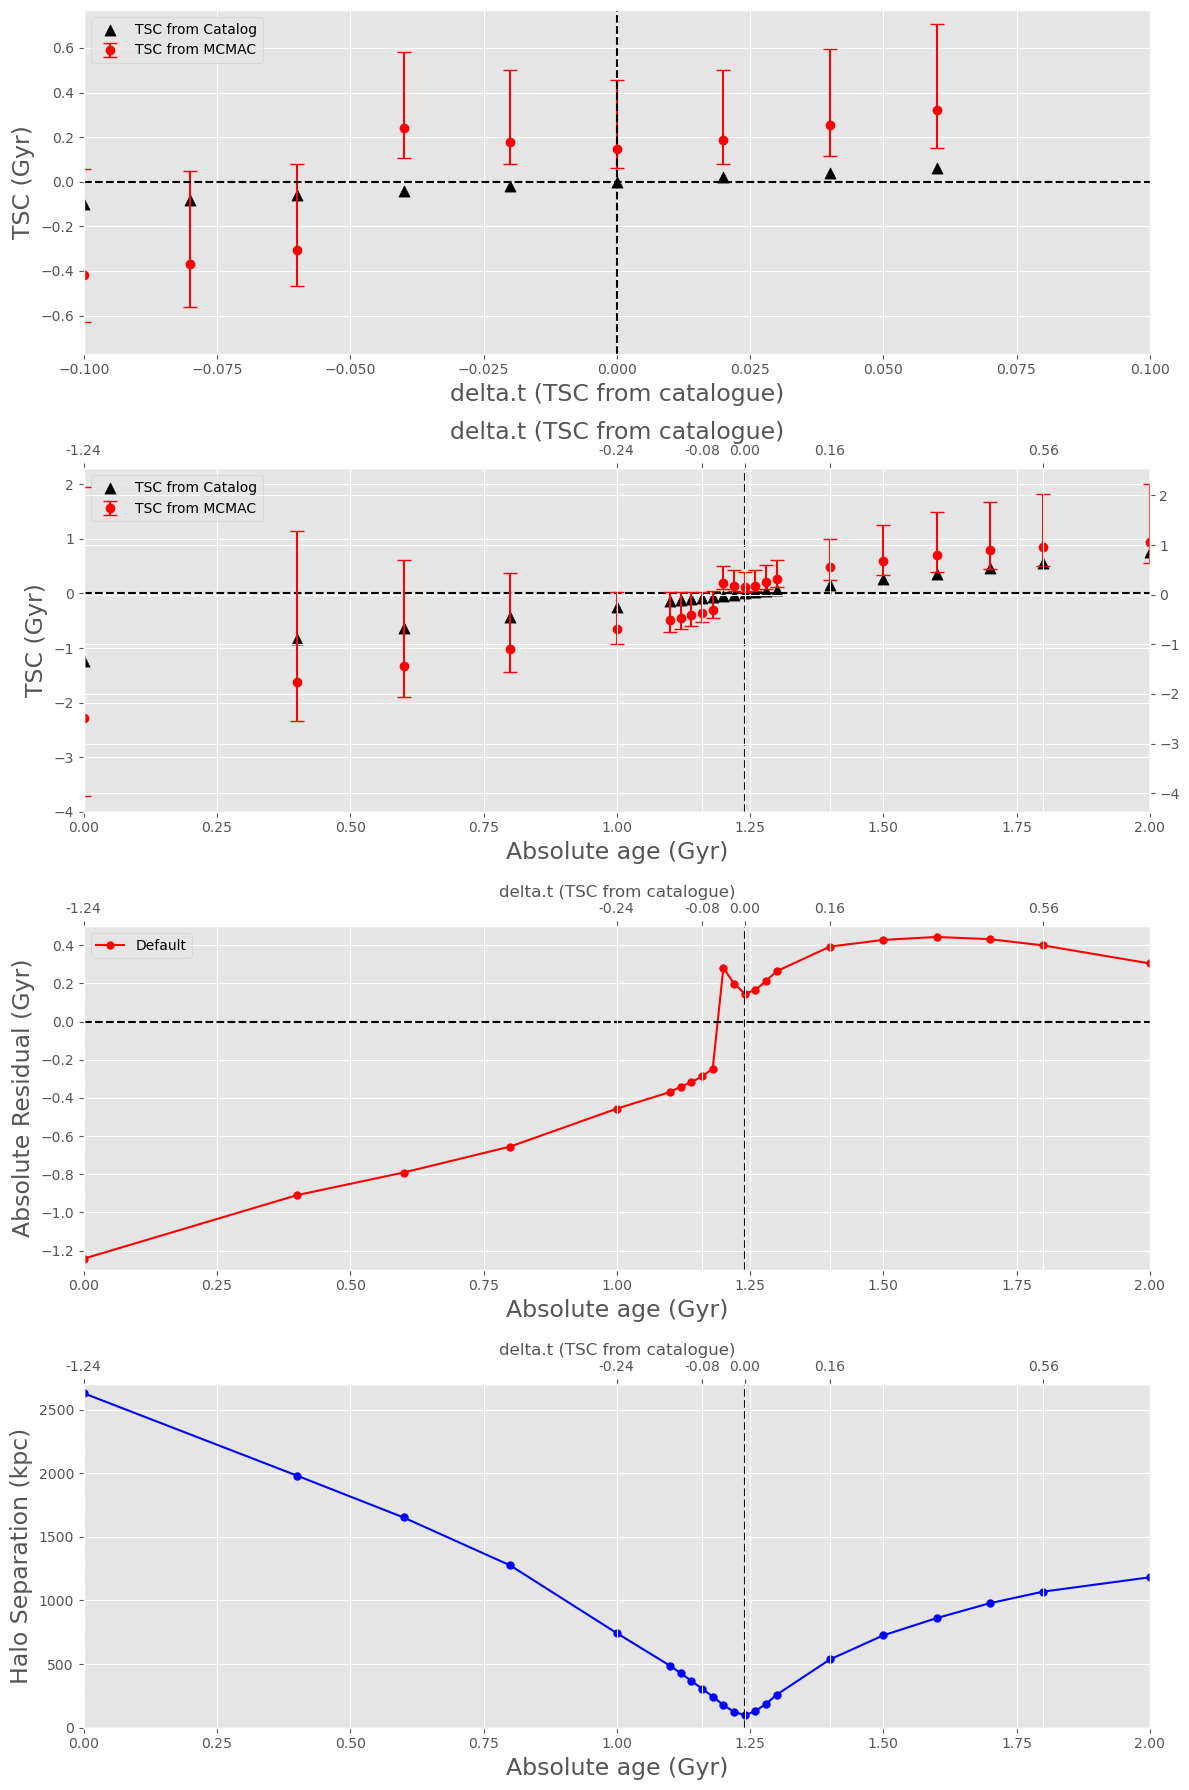

Cross-Validated MAE: 0.41 ± 0.12
Cross-Validated RMSE: 0.45 ± 0.15
Cross-Validated R²: -9.59 ± 13.34
Cross-Validated Correlation Coefficient: 1.00 ± 0.01
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.564941,0.742396,-0.685367,0.992072
1,0.514303,0.586975,-1.314070,0.980551
2,0.299150,0.315368,-0.182602,1.000000
3,0.555726,0.564532,-30.869663,1.000000
4,0.287245,0.319874,-5.054406,1.000000
5,0.418016,0.418776,-16.537329,1.000000
6,0.519101,0.586017,-3.083425,1.000000
7,0.311226,0.311297,0.475901,1.000000
8,0.247041,0.249443,-37.888588,1.000000
9,0.386230,0.388897,-0.798348,1.000000


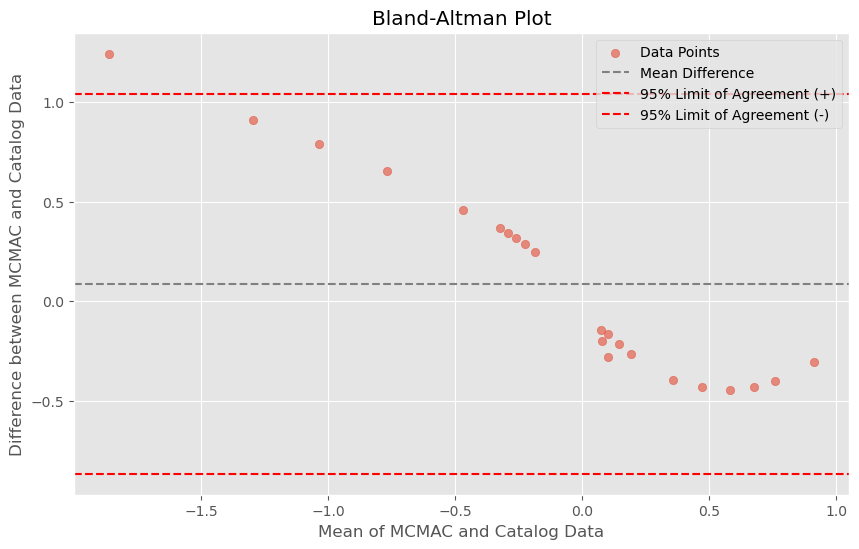

In [8]:
filename_default = '../output_default/zh_1to3_b0.5_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to3_b0.5_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to3_b0.5_z_MCMAC.txt'


zoom_x_range = [-0.1, 0.1]
zoom_y_range = [-0.77, 0.77]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2.3]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 2700]
absolute_merge_time = 2 - 0.76

plotImage(filename_default, filename_20degree, filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:3 b=1000kpc

Pearson Correlation Coefficient: 0.94


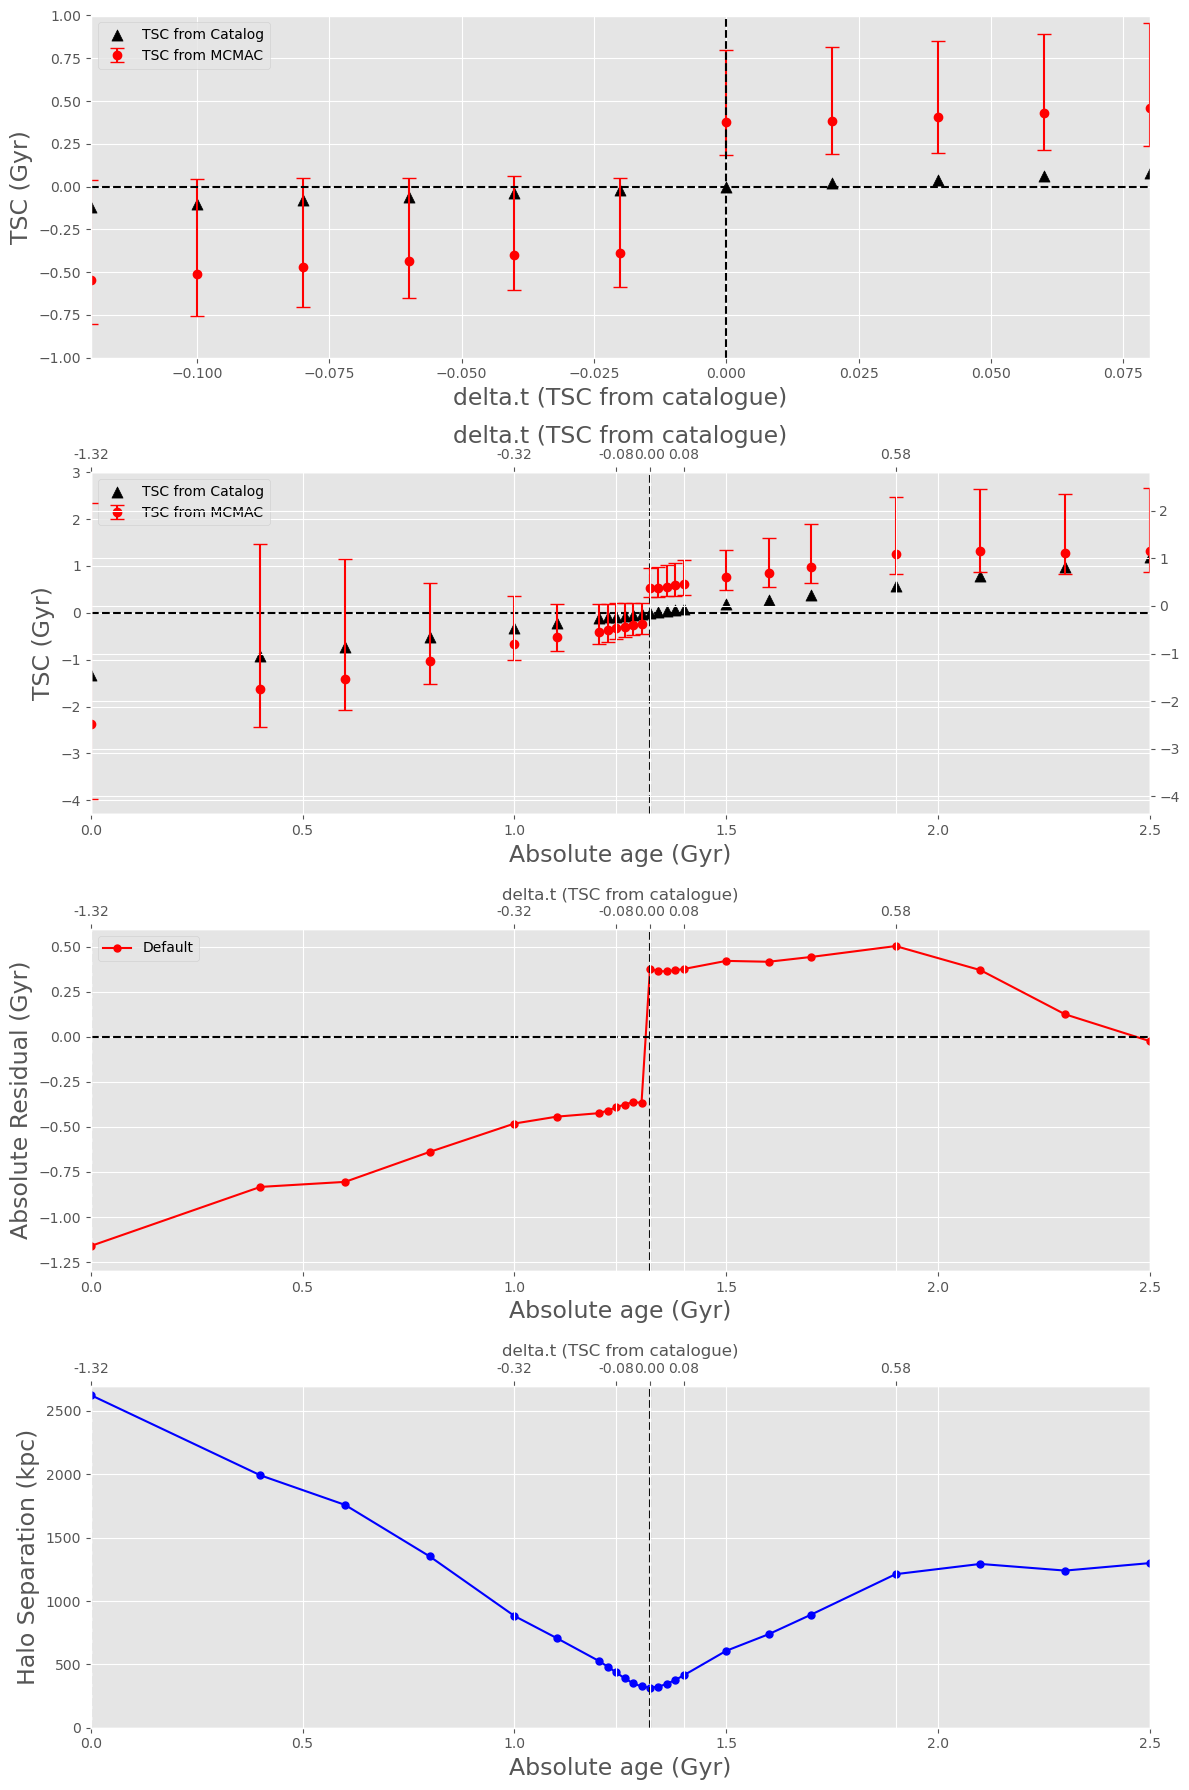

Cross-Validated MAE: 0.44 ± 0.12
Cross-Validated RMSE: 0.47 ± 0.13
Cross-Validated R²: -9.67 ± 23.99
Cross-Validated Correlation Coefficient: 0.99 ± 0.01
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.642949,0.739891,-0.398431,0.978122
1,0.386198,0.386848,-5.500300,0.997597
2,0.522849,0.566966,0.335113,0.979047
3,0.542331,0.573818,-2.628064,0.962338
4,0.504624,0.522055,-2.240678,1.000000
5,0.303301,0.351476,0.707609,1.000000
6,0.463443,0.465265,-4.411791,1.000000
7,0.215995,0.289563,0.795296,1.000000
8,0.363056,0.363059,-81.382252,1.000000
9,0.433645,0.433769,-2.010482,1.000000


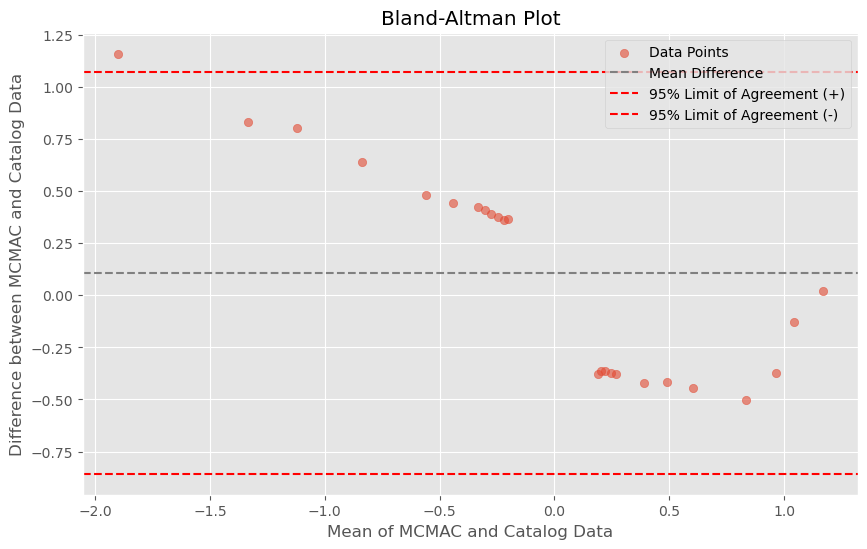

In [9]:
filename_default = '../output_default/zh_1to3_b1_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to3_b1_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to3_b1_z_MCMAC.txt'

zoom_x_range = [-0.12, 0.08]
zoom_y_range = [-1, 1]
plot1_x_range = [0, 2.5]
plot1_y_range = [-4.3, 3]
plot2_x_range = [0, 2.5]
plot2_y_range = [-1.3, 0.6]
plot3_x_range = [0, 2.5]
plot3_y_range = [0, 2700]
absolute_merge_time = 2.5 - 1.18

plotImage(filename_default, filename_20degree, filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:10 b=0kpc

Pearson Correlation Coefficient: 0.93


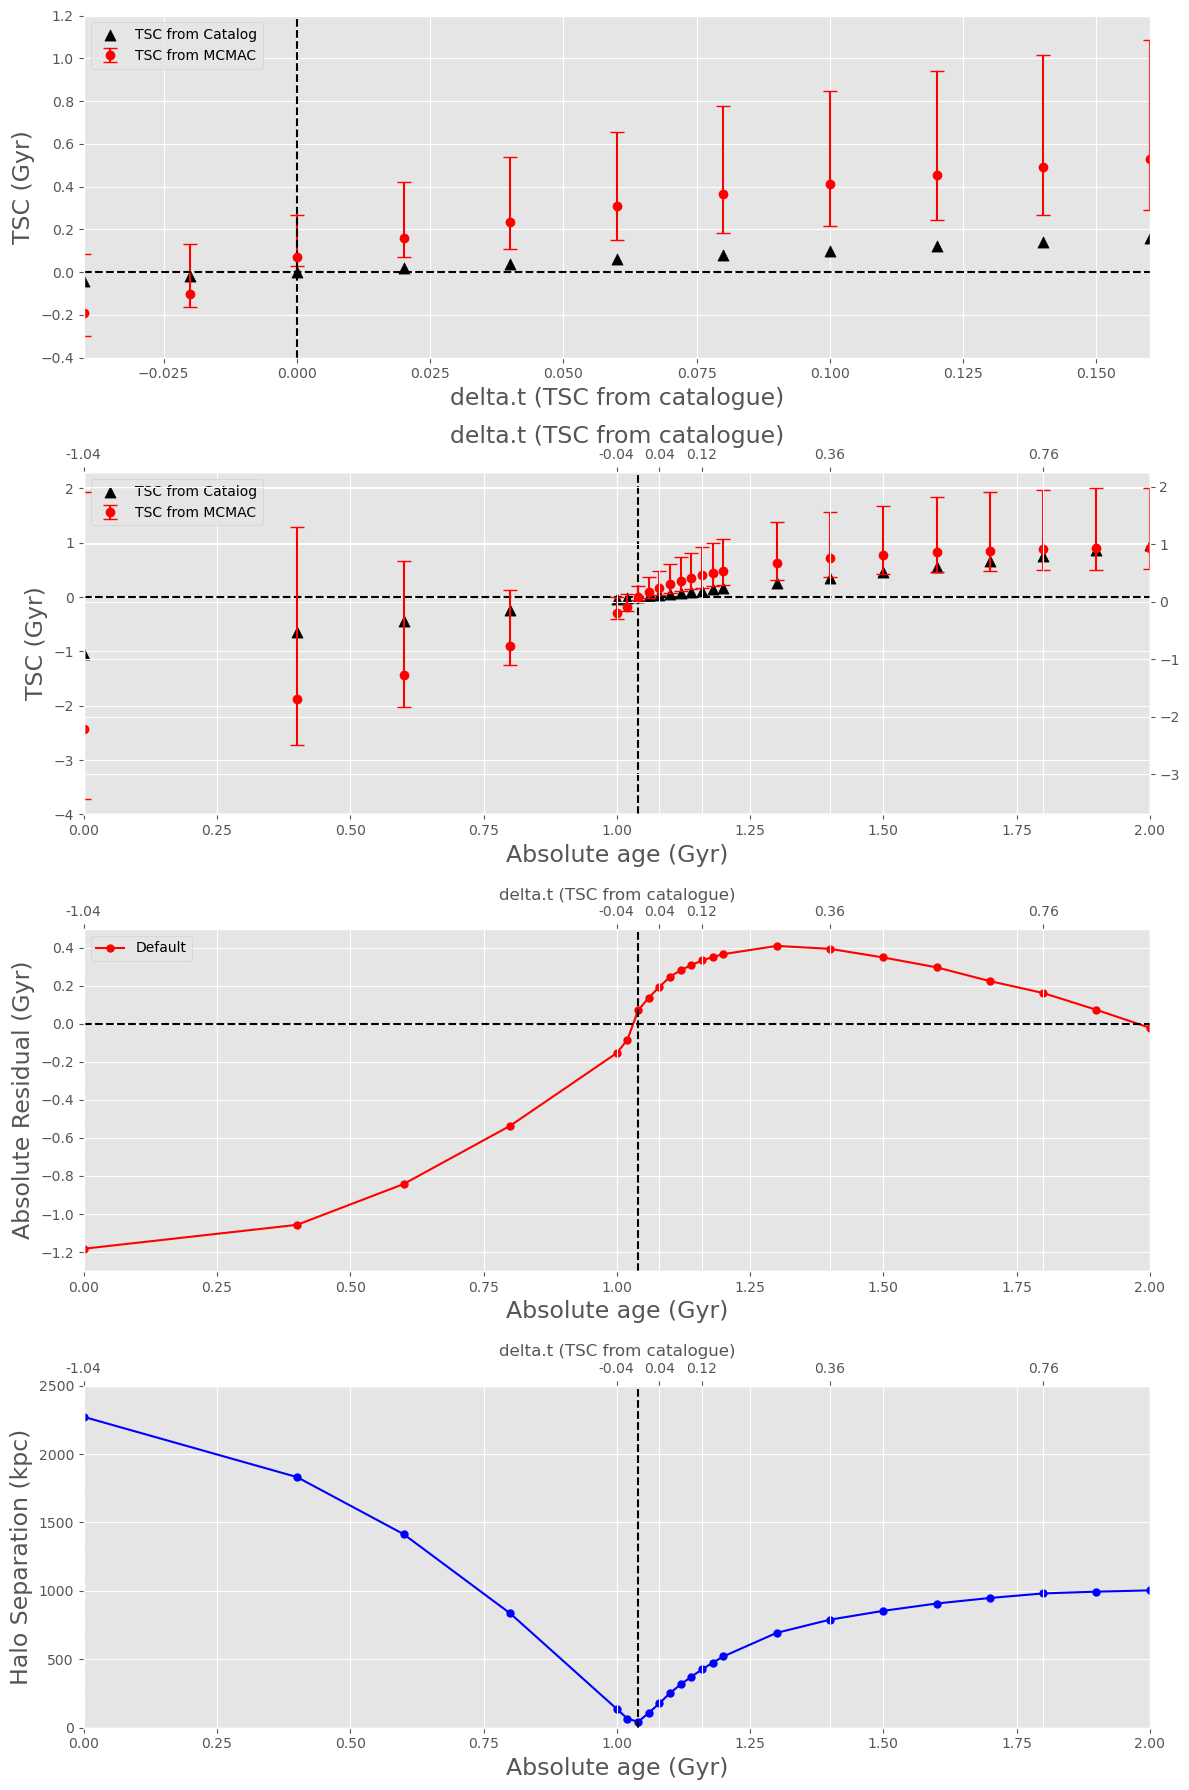

Cross-Validated MAE: 0.33 ± 0.17
Cross-Validated RMSE: 0.38 ± 0.21
Cross-Validated R²: -7.36 ± 19.67
Cross-Validated Correlation Coefficient: 1.00 ± 0.01
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.613689,0.736845,-0.662063,0.999606
1,0.292942,0.301010,-1.732779,0.978919
2,0.497250,0.644979,-2.676339,0.997522
3,0.576170,0.634743,-4.526740,1.000000
4,0.349242,0.395974,0.372820,1.000000
5,0.225481,0.236791,0.376999,1.000000
6,0.234601,0.284231,-0.292597,1.000000
7,0.078969,0.098445,0.956128,1.000000
8,0.325109,0.327814,-66.163912,1.000000
9,0.148339,0.167104,0.743584,1.000000


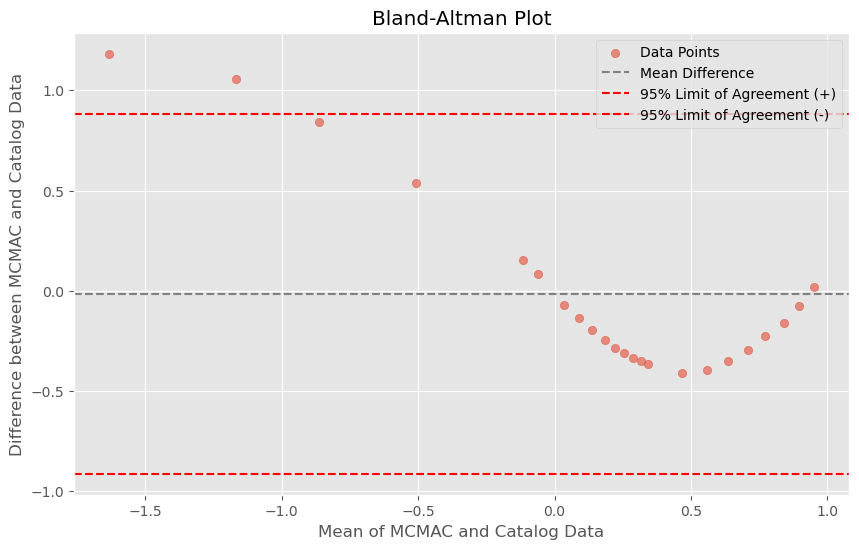

In [10]:
filename_default = '../output_default/zh_1to10_b0_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to10_b0_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to10_b0_z_MCMAC.txt'

zoom_x_range = [-0.04, 0.16]
zoom_y_range = [-0.4, 1.2]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2.3]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 2500]
absolute_merge_time = 2 - 0.96

plotImage(filename_default, filename_20degree, filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:10 b=500kpc

Pearson Correlation Coefficient: 0.99


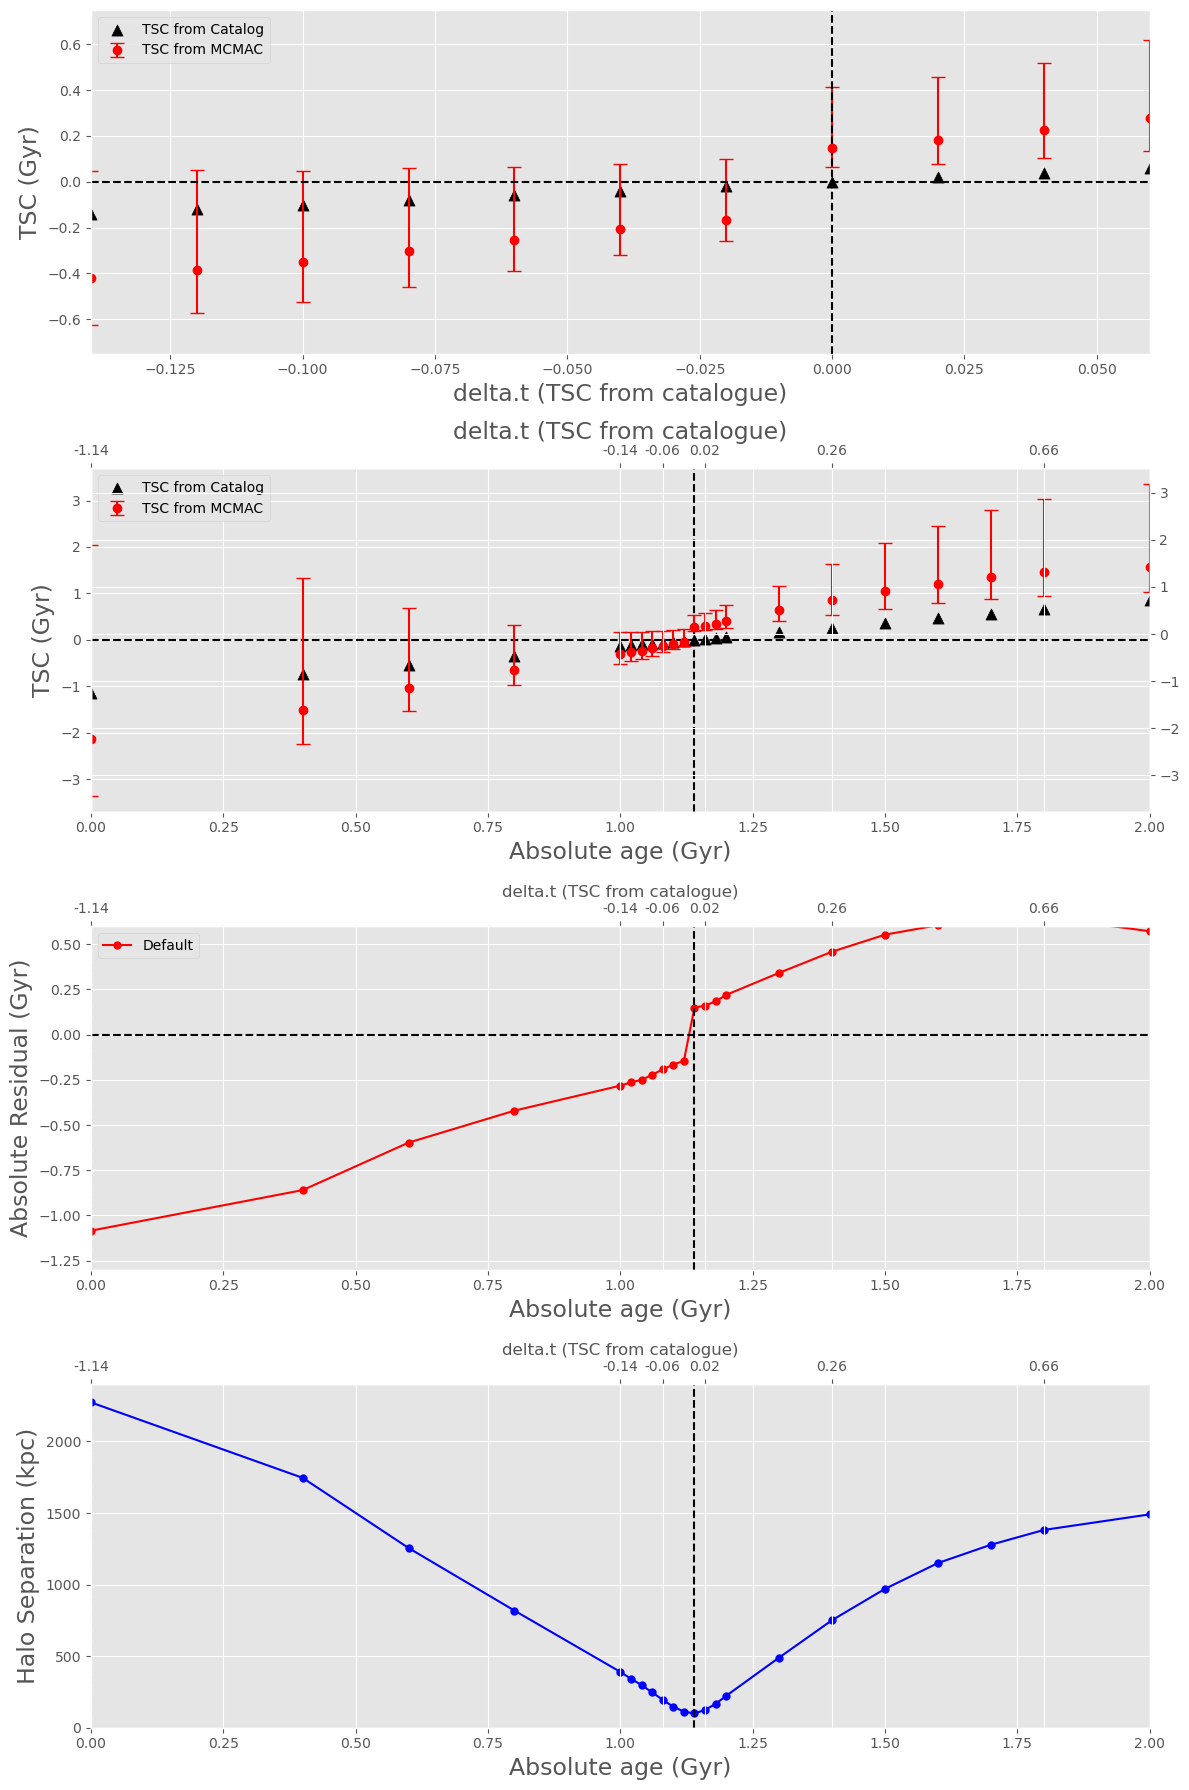

Cross-Validated MAE: 0.40 ± 0.09
Cross-Validated RMSE: 0.45 ± 0.12
Cross-Validated R²: -7.09 ± 9.33
Cross-Validated Correlation Coefficient: 1.00 ± 0.00
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.486949,0.644681,-0.456138,0.994166
1,0.488498,0.555577,-1.182585,0.992308
2,0.400268,0.472347,-1.048778,1.000000
3,0.351402,0.358150,-11.827160,1.000000
4,0.356658,0.407025,-4.732499,1.000000
5,0.531991,0.537004,-27.837372,1.000000
6,0.381444,0.438331,-2.074146,1.000000
7,0.396930,0.433657,0.148672,1.000000
8,0.182470,0.186254,-20.681521,1.000000
9,0.447946,0.489605,-1.201224,1.000000


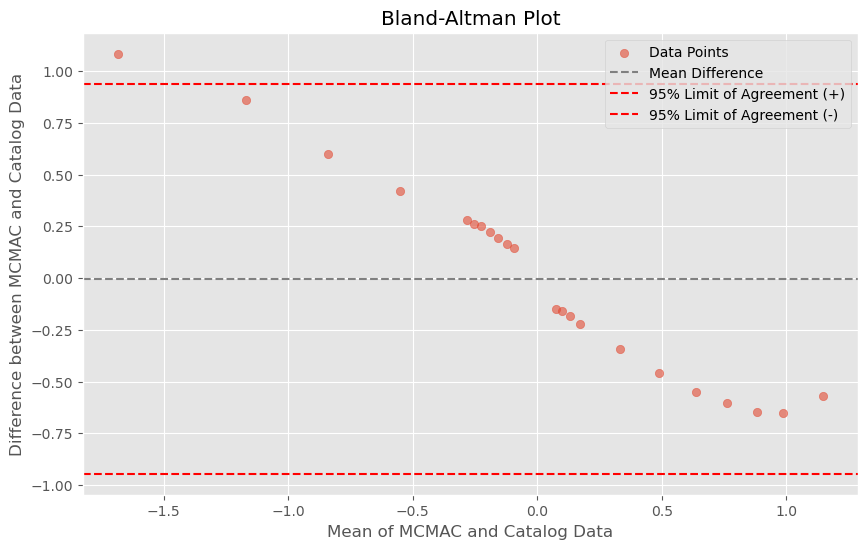

In [11]:
filename_default = '../output_default/zh_1to10_b0.5_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to10_b0.5_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to10_b0.5_z_MCMAC.txt'

zoom_x_range = [-0.14, 0.06]
zoom_y_range = [-0.75, 0.75]
plot1_x_range = [0, 2]
plot1_y_range = [-3.7, 3.7]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.6]
plot3_x_range = [0, 2]
plot3_y_range = [0, 2400]
absolute_merge_time = 2.4 - 1.26

plotImage(filename_default, filename_20degree, filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:10 b=1000kpc

Pearson Correlation Coefficient: 0.95


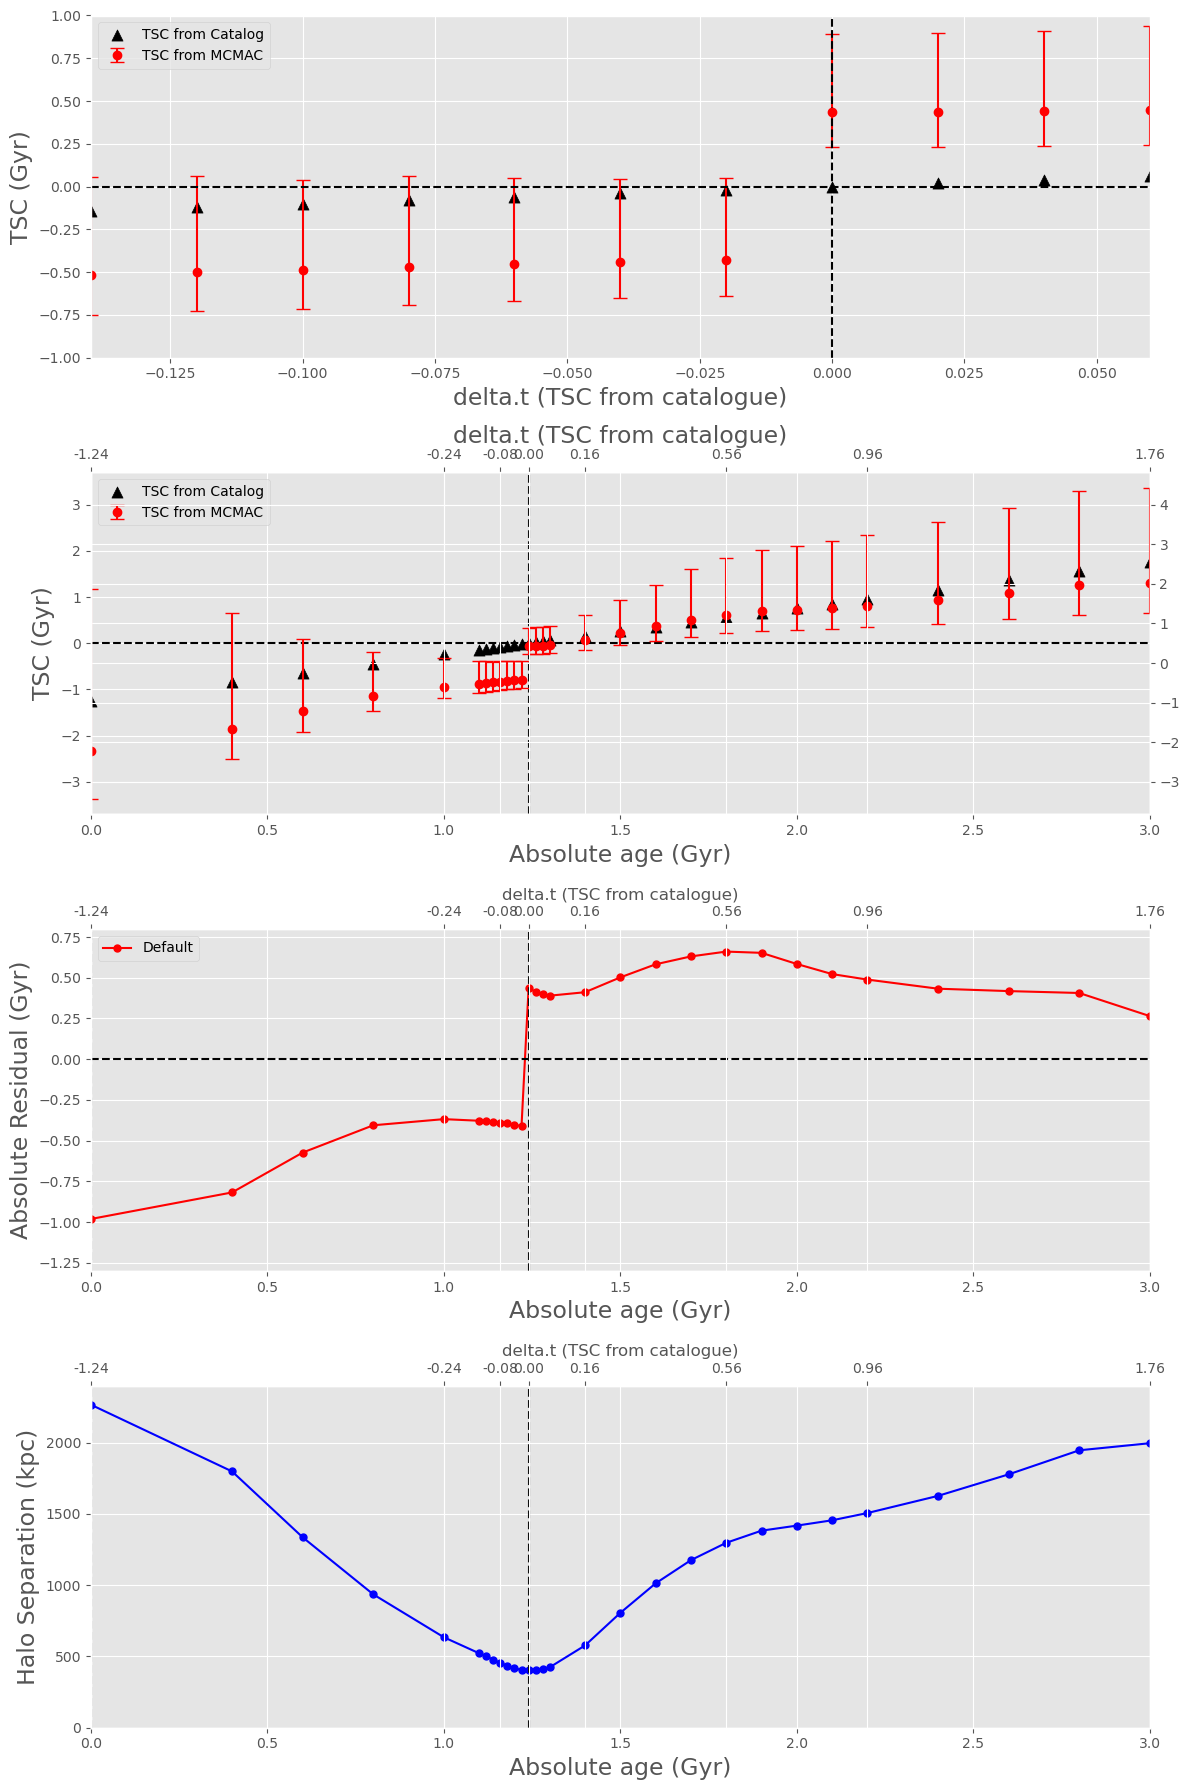

Cross-Validated MAE: 0.49 ± 0.08
Cross-Validated RMSE: 0.50 ± 0.09
Cross-Validated R²: -20.10 ± 46.55
Cross-Validated Correlation Coefficient: 0.98 ± 0.04
Cross-Validation Results:


,MAE,RMSE,R²,Correlation Coefficient
0,0.417481,0.417660,0.644742,0.999920
1,0.455933,0.464924,-0.411341,0.999905
2,0.683902,0.721742,0.568306,0.987764
3,0.405593,0.405744,-153.338677,0.873241
4,0.562567,0.593314,-0.740768,0.991731
5,0.479797,0.486417,0.470295,0.998442
6,0.453647,0.456401,0.568037,0.995064
7,0.502725,0.531083,0.262081,0.993103
8,0.396375,0.396421,-46.781874,0.922296
9,0.505388,0.520787,-2.224955,1.000000


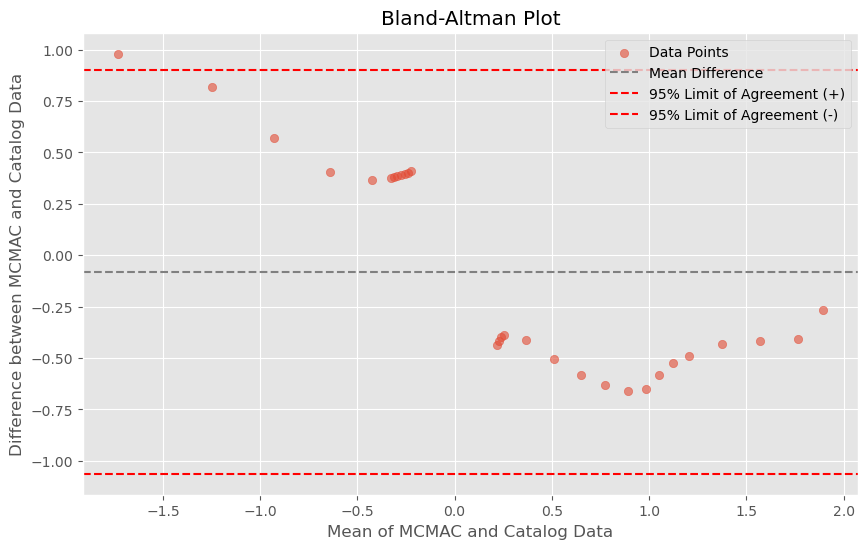

In [12]:
filename_default = '../output_default/zh_1to10_b1_z_MCMAC.txt'
filename_20degree = '../output_20degree/zh_1to10_b1_z_MCMAC.txt'
filename_60degree = '../output_60degree/zh_1to10_b1_z_MCMAC.txt'

zoom_x_range = [-0.14, 0.06]
zoom_y_range = [-1, 1]
plot1_x_range = [0, 3]
plot1_y_range = [-3.7, 3.7]
plot2_x_range = [0, 3]
plot2_y_range = [-1.3, 0.8]
plot3_x_range = [0, 3]
plot3_y_range = [0, 2400]
absolute_merge_time = 3 - 1.76

plotImage(filename_default, filename_20degree, filename_60degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

Results of correlation coefficient:


,filename,CorrelationCoefficient
0,1:1 (b=0),0.974309
1,1:1 (b=0.5),0.976576
2,1:1 (b=1),0.965026
3,1:3 (b=0),0.969441
4,1:3 (b=0.5),0.974153
5,1:3 (b=1),0.939583
6,1:10 (b=0),0.928570
7,1:10 (b=0.5),0.987255
8,1:10 (b=1),0.951252


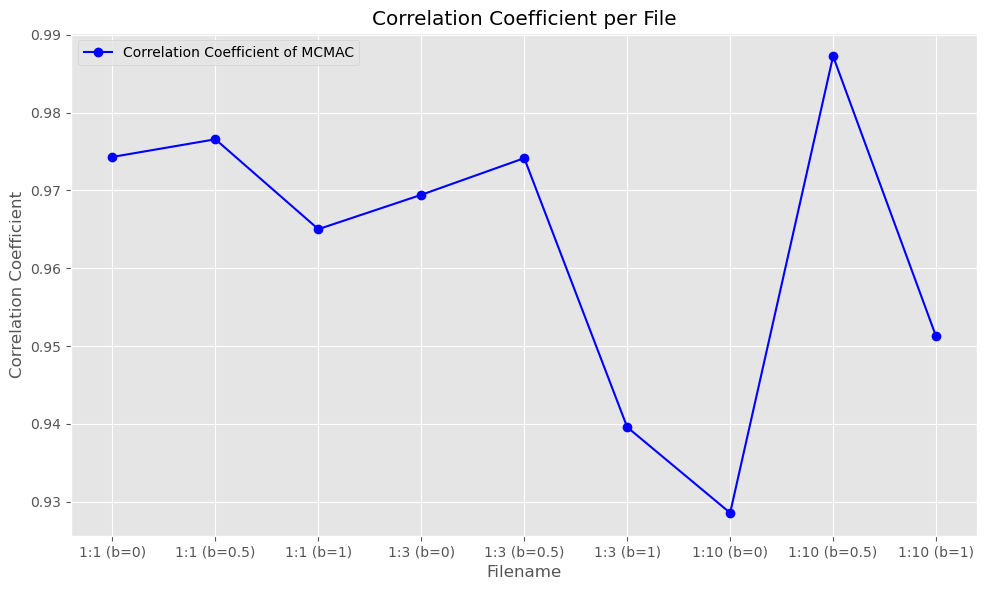

In [13]:
results_df_correlation_coefficient = pd.DataFrame(results_correlation_coefficient)
print("Results of correlation coefficient:")
display(results_df_correlation_coefficient)

# プロットの設定
plt.figure(figsize=(10, 6))
plt.plot(results_df_correlation_coefficient['filename'], results_df_correlation_coefficient['CorrelationCoefficient'], 'b-', marker='o', label='Correlation Coefficient of MCMAC')
plt.title('Correlation Coefficient per File')
plt.xlabel('Filename')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Results for 0-90 degree:


,filename,MAE,RMSE,R²
0,1:1 (b=0),0.422931,0.520465,-0.328451
1,1:1 (b=0.5),0.441105,0.524029,-0.294872
2,1:1 (b=1),0.457273,0.511360,-0.529676
3,1:3 (b=0),0.392904,0.498735,-0.305018
4,1:3 (b=0.5),0.422055,0.494807,-0.277374
5,1:3 (b=1),0.452130,0.503163,0.147686
6,1:10 (b=0),0.351629,0.458347,-0.010195
7,1:10 (b=0.5),0.410207,0.481139,-0.201565
8,1:10 (b=1),0.485684,0.507842,0.442074



Results for 0-20 degree:


,filename,MAE,RMSE,R²
0,1:1 (b=0),0.174483,0.213455,0.776551
1,1:1 (b=0.5),0.178530,0.209940,0.792171
2,1:1 (b=1),0.187141,0.204098,0.756319
3,1:3 (b=0),0.162111,0.204631,0.780306
4,1:3 (b=0.5),0.166072,0.191598,0.808472
5,1:3 (b=1),0.212064,0.224698,0.830026
6,1:10 (b=0),0.169208,0.215192,0.777327
7,1:10 (b=0.5),0.159685,0.179343,0.833055
8,1:10 (b=1),0.200804,0.219476,0.895794


Average Improvement
{'MAE': 0.24731315836274406, 'RMSE': 0.29305066822573844, 'R²': 0.9563791538895132}


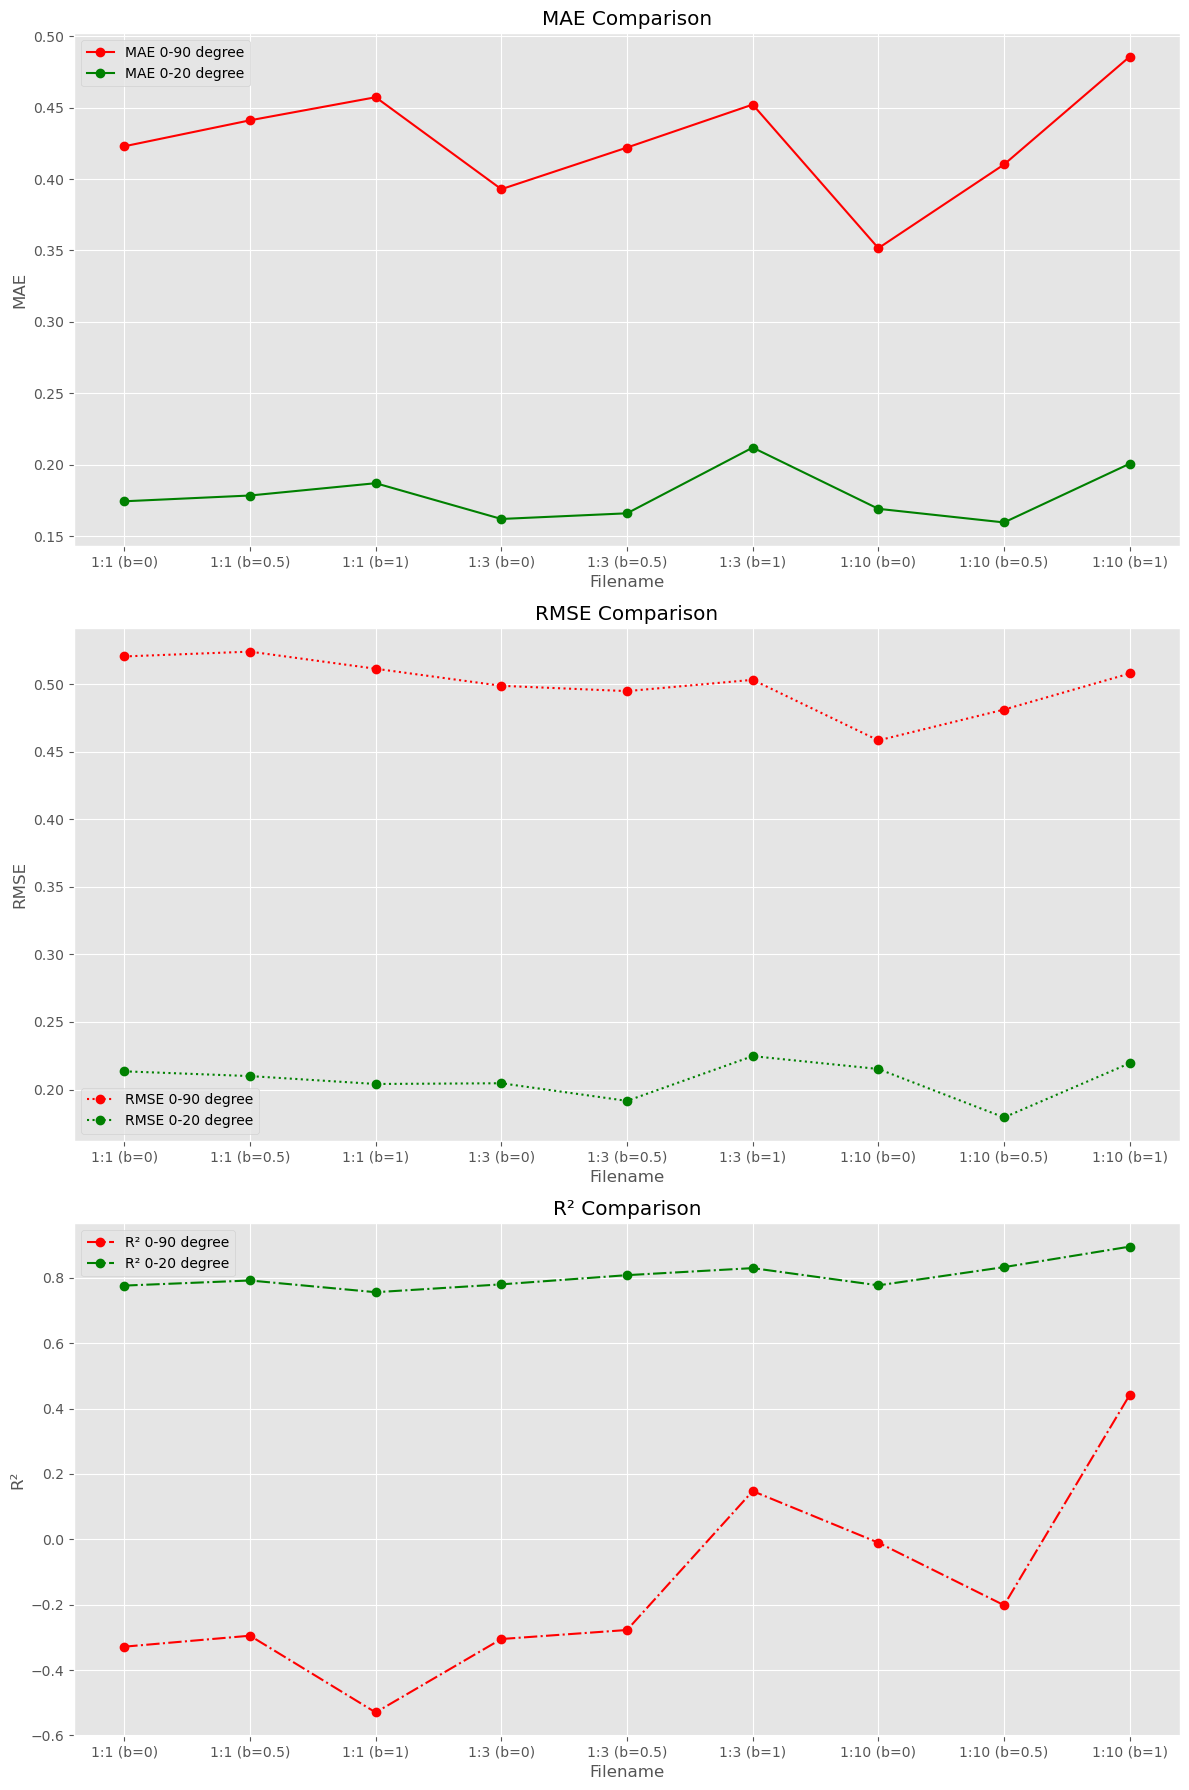

In [14]:
# Convert results lists to dataframes
results_df_0_90 = pd.DataFrame(results_0_90)
results_df_0_20 = pd.DataFrame(results_0_20)

# Print the dataframes
print("Results for 0-90 degree:")
display(results_df_0_90)
print("\nResults for 0-20 degree:")
display(results_df_0_20)

average_improvement = {
    "MAE": results_df_0_90["MAE"].mean() - results_df_0_20["MAE"].mean(),
    "RMSE": results_df_0_90["RMSE"].mean() - results_df_0_20["RMSE"].mean(),
    "R²": results_df_0_20["R²"].mean() - results_df_0_90["R²"].mean()
}

print("Average Improvement")
print(average_improvement)


# プロットの設定
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# MAEのプロット
axs[0].plot(results_df_0_90['filename'], results_df_0_90['MAE'], 'r-', marker='o', label='MAE 0-90 degree')
axs[0].plot(results_df_0_20['filename'], results_df_0_20['MAE'], 'g-', marker='o', label='MAE 0-20 degree')
axs[0].set_title('MAE Comparison')
axs[0].set_xlabel('Filename')
axs[0].set_ylabel('MAE')
axs[0].legend()
axs[0].grid(True)

# RMSEのプロット
axs[1].plot(results_df_0_90['filename'], results_df_0_90['RMSE'], 'r:', marker='o', label='RMSE 0-90 degree')
axs[1].plot(results_df_0_20['filename'], results_df_0_20['RMSE'], 'g:', marker='o', label='RMSE 0-20 degree')
axs[1].set_title('RMSE Comparison')
axs[1].set_xlabel('Filename')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].grid(True)

# R²のプロット
axs[2].plot(results_df_0_90['filename'], results_df_0_90['R²'], 'r-.', marker='o', label='R² 0-90 degree')
axs[2].plot(results_df_0_20['filename'], results_df_0_20['R²'], 'g-.', marker='o', label='R² 0-20 degree')
axs[2].set_title('R² Comparison')
axs[2].set_xlabel('Filename')
axs[2].set_ylabel('R²')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()